# Time Series Forecasting in TensorFlow (BitPredict)
In this notebook, a series of models are built in an attempt to predict the price of Bitcoin, which mainly covers the following topics:


*   Get time series data
*   Format data for a time series problem
*   Evaluating a time series forecasting model
*   Setting up a series of deeping learning modelling experiments
    1.   Dense (fully-connected) networks
    2.   Sequence models (LSTM and 1D CNN)
    3.   Ensembling (combining multiple models together)
    4.   Multivariate models
    5.   Replicating the N-BEATS algorithms using TensorFlow layer subclassing


*   Making predictions (forecasts) with a time series model
*   Creating prediction intervals for time series model forecasts



# Setup

In [2]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.utils import plot_model

In [3]:
# Check for GPU
!nvidia-smi

Thu Jul 21 13:57:41 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Get time series data and preprocess

In [4]:
# Download Bitcoin historical data from Github
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv 

--2022-07-21 13:57:41--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 178509 (174K) [text/plain]
Saving to: ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’

BTC_USD_2013-10-01_ 100%[===================>] 174.33K  --.-KB/s    in 0.02s   

2022-07-21 13:57:41 (9.34 MB/s) - ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’ saved [178509/178509]



In [5]:
# Import time series data with Pandas and parse dates
df = pd.read_csv('BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv',
                 parse_dates=['Date'],
                 index_col=['Date'])
df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


In [6]:
# Get some more information
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2013-10-01 to 2021-05-18
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2787 non-null   object 
 1   Closing Price (USD)  2787 non-null   float64
 2   24h Open (USD)       2787 non-null   float64
 3   24h High (USD)       2787 non-null   float64
 4   24h Low (USD)        2787 non-null   float64
dtypes: float64(4), object(1)
memory usage: 130.6+ KB


In [7]:
# How many samples are there
len(df)

2787

In [8]:
# Only keep date index and closing price
bitcoin_prices = pd.DataFrame(df['Closing Price (USD)']).rename(columns={'Closing Price (USD)': 'Price'})
bitcoin_prices

,Price
Date,
2013-10-01,123.654990
2013-10-02,125.455000
2013-10-03,108.584830
2013-10-04,118.674660
2013-10-05,121.338660
...,...
2021-05-14,49764.132082
2021-05-15,50032.693137
2021-05-16,47885.625255


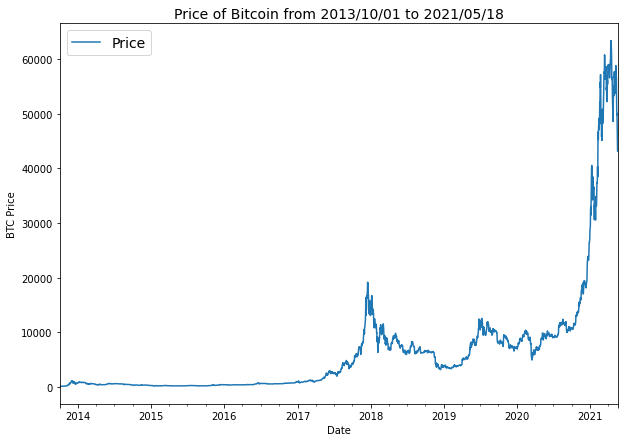

In [9]:
# Visualize the time series data
bitcoin_prices.plot(figsize=(10, 7))
plt.ylabel('BTC Price')
plt.title('Price of Bitcoin from 2013/10/01 to 2021/05/18', fontsize=14)
plt.legend(fontsize=14)
plt.show()

# Train & test split

In [10]:
# Get bitcoin data array
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices['Price'].to_numpy()

timesteps[:10], prices[:10]

(array(['2013-10-01T00:00:00.000000000', '2013-10-02T00:00:00.000000000',
        '2013-10-03T00:00:00.000000000', '2013-10-04T00:00:00.000000000',
        '2013-10-05T00:00:00.000000000', '2013-10-06T00:00:00.000000000',
        '2013-10-07T00:00:00.000000000', '2013-10-08T00:00:00.000000000',
        '2013-10-09T00:00:00.000000000', '2013-10-10T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
        121.795  , 123.033  , 124.049  , 125.96116]))

In [11]:
# Create train and test sets
split_size = int(0.8 * len(prices))

X_train, y_train = timesteps[:split_size], prices[:split_size]
X_test, y_test = timesteps[split_size:], prices[split_size:]

len(X_train), len(y_train), len(X_test), len(y_test)

(2229, 2229, 558, 558)

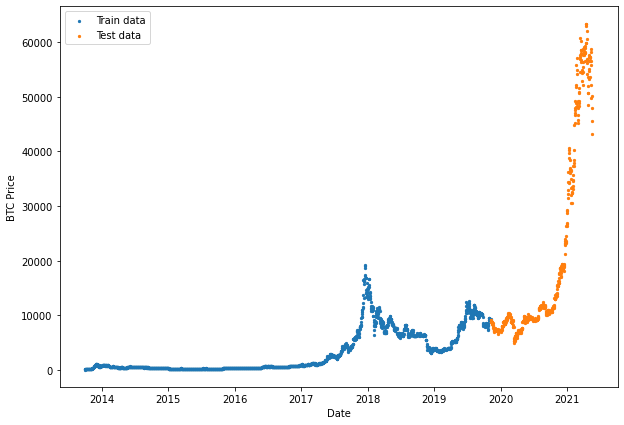

In [12]:
# Visualize the train and test data
plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s=5, label='Train data')
plt.scatter(X_test, y_test, s=5, label='Test data')
plt.xlabel('Date')
plt.ylabel('BTC Price')
plt.legend(fontsize=10)
plt.show()

In [13]:
# Create a function to plot time series data
def plot_time_series(timesteps, values, format='.', start=0, end=None, label=None):
  """
  Plot a timesteps (a series of points in time) against values (a series values across timesteps).

  Args:
    timesteps: array of timesteps.
    values: array of values across timesteps.
    format: style of plot, default to ".".
    start: where to start the plot (setting a value for the index of timesteps & values start from)
    ens: where to end the plot (setting a value for the index of timesteps & values end at)
    label: label to show on plot of values
  """
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel('Date')
  plt.ylabel('BTC Price')
  if label:
    plt.legend(fontsize=14)
  plt.grid(True)

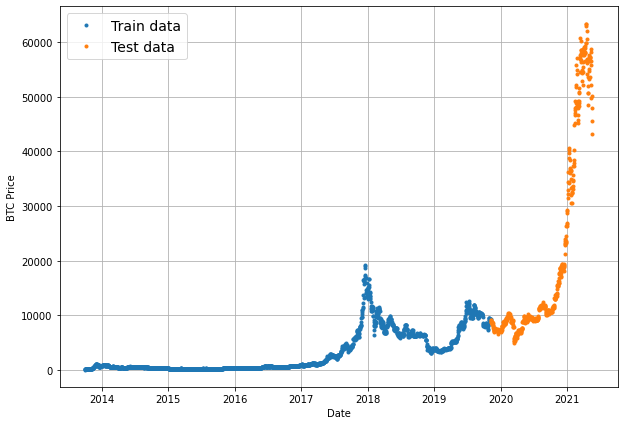

In [14]:
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label='Train data')
plot_time_series(timesteps=X_test, values=y_test, label='Test data')

# Create a baseline model (Naïve forecast)
One of the most common baseline models for time series forecasting, the naïve model (also called the naïve forecast), requires no training at all.

In [15]:
# Create a naïve forecast
naive_forecast = y_test[:-1]

naive_forecast[:10], naive_forecast[-10:]

(array([9226.48582088, 8794.35864452, 8798.04205463, 9081.18687849,
        8711.53433917, 8760.89271814, 8749.52059102, 8656.97092235,
        8500.64355816, 8469.2608989 ]),
 array([57107.12067189, 58788.20967893, 58102.19142623, 55715.54665129,
        56573.5554719 , 52147.82118698, 49764.1320816 , 50032.69313676,
        47885.62525472, 45604.61575361]))

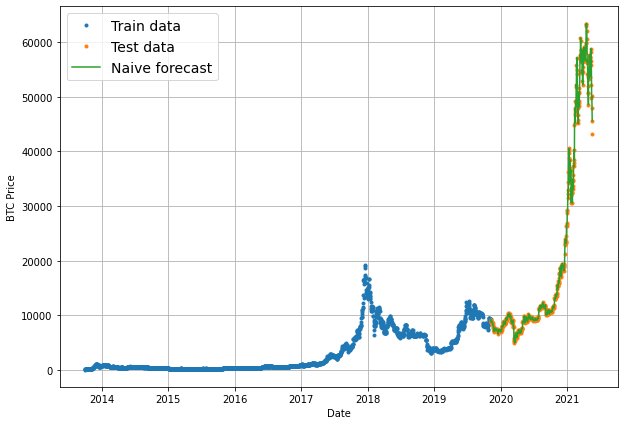

In [16]:
# Plot naive forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label='Train data')
plot_time_series(timesteps=X_test, values=y_test, label='Test data')
plot_time_series(timesteps=X_test[1:], values=naive_forecast, format='-', label='Naive forecast')

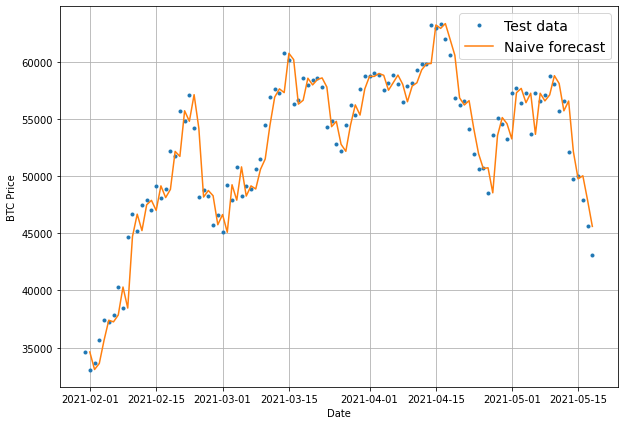

In [17]:
# Zoom in to take a better look
plt.figure(figsize=(10, 7))
offset = 450
plot_time_series(timesteps=X_test, values=y_test, start=offset, label='Test data')
plot_time_series(timesteps=X_test[1:], values=naive_forecast, start=offset, format='-', label='Naive forecast')

# Evaluate a time series model
A few common regression metrics:
*  MAE - mean absolute error
*  MSE - mean squared error
*  RMSE - root mean squared erroe
*  MAPE/sMAPE - (symmetric) mean absolute percentage error
*  MASE - mean absolute scaled error

## Implement MASE

In [18]:
def mean_absolute_scaled_error(y_true, y_pred):
  """
  Implement MASE (assuming no seasonality).
  """
  mae = tf.reduce_mean(tf.abs(y_true - y_pred))

  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1]))

  MASE = mae/mae_naive_no_season

  return MASE

## Evaluate with various metrics

In [19]:
def evaluate_preds(y_true, y_pred):
  # Make sure float32 dtype (for metric calculation)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various evaluation metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  # Reduce to single scalar if with long horizons
  if mae.ndim > 0:
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)
    mase = tf.reduce_mean(mase)

  metrics = {'MAE': mae.numpy(),
             'MSE': mse.numpy(),
             'RMSE': rmse.numpy(),
             'MAPE': mape.numpy(),
             'MASE': mase.numpy()}
  return metrics

In [20]:
# Test function on the naive forecast
naive_results = evaluate_preds(y_true=y_test[1:], y_pred=naive_forecast)
naive_results

{'MAE': 567.9802,
 'MAPE': 2.516525,
 'MASE': 0.99957,
 'MSE': 1147547.0,
 'RMSE': 1071.2362}

# Windowing dataset
Window the time series dataset to turn the data into **windows** and **horizons** of **specified sizes** for supervised learning problem.

## Sliding window vectorization with Numpy

In [21]:
# Setup global variables for window and horizon size
HORIZON = 1
WINDOW_SIZE = 7

In [22]:
# Create function to label windowed data
def get_labelled_windows(x, horizon=HORIZON):
  """
  Ctreate label for windowed dataset.
  """
  return x[:, :-horizon], x[:,-horizon:]

In [23]:
# Test out the window labelling function
test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(8)+1, axis=0), horizon=HORIZON)
print(f'Window: {tf.squeeze(test_window.numpy())} --> Label: {tf.squeeze(test_label.numpy())}')

Window: [1 2 3 4 5 6 7] --> Label: 8


In [24]:
# Create a function to view Numpy arrays as windows
def make_windows(x, window_size=WINDOW_SIZE, horizon=HORIZON):
  """
  Turns a 1D array into a 2D array of sequential labelled windows of window_size with horizon size labels.
  """
  # Create a window of specified window_size (add the horizon on the end for later labelling)
  window_step = np.expand_dims(np.arange(window_size + horizon), axis=0)

  # Create a 2d array of multiple window steps
  window_indexes = window_step + np.expand_dims(np.arange(len(x) - (window_size + horizon) + 1), axis=0).T

  # Index on the target array (time series) with 2d array of multiple window steps
  windowed_array = x[window_indexes]

  # Get the labelled windows
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)

  return windows, labels

In [25]:
# Prepare the full dataset into labelled window dataset
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
full_windows.shape, full_labels.shape

((2780, 7), (2780, 1))

In [26]:
# Visualize a few examples for better understanding
for i in range(3):
  print(f'Window: {full_windows[i]} --> Label: {full_labels[i]}')

Window: [123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ] --> Label: [123.033]
Window: [125.455   108.58483 118.67466 121.33866 120.65533 121.795   123.033  ] --> Label: [124.049]
Window: [108.58483 118.67466 121.33866 120.65533 121.795   123.033   124.049  ] --> Label: [125.96116]


In [27]:
# Train-Test split the dataset
def make_train_test_split(windows, labels, test_split=0.2):
  """
  Split matching pairs of windows and labels into train and test datasets.
  """
  split_size = int(len(windows) * (1-test_split))

  train_windows = windows[:split_size]
  train_labels = labels[:split_size]

  test_windows = windows[split_size:]
  test_labels = labels[split_size:]
  
  return train_windows, test_windows, train_labels, test_labels

In [28]:
train_windows, test_windows, train_labels, test_labels = make_train_test_split(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

In [29]:
len(y_train), len(y_test)

(2229, 558)

In [30]:
np.squeeze(train_labels[:10]), y_train[WINDOW_SIZE:][:10]

(array([123.033  , 124.049  , 125.96116, 125.27966, 125.9275 , 126.38333,
        135.24199, 133.20333, 142.76333, 137.92333]),
 array([123.033  , 124.049  , 125.96116, 125.27966, 125.9275 , 126.38333,
        135.24199, 133.20333, 142.76333, 137.92333]))

In [31]:
# Check to see if same
np.array_equal(np.squeeze(train_labels[:-2]), y_train[WINDOW_SIZE:])

True

## Sliding windows with TensorFlow module

In [32]:
btc_dataset = tf.keras.utils.timeseries_dataset_from_array(data=prices[:-WINDOW_SIZE],
                                                           targets=prices[WINDOW_SIZE:],
                                                           sequence_length=WINDOW_SIZE,
                                                           batch_size=32)
btc_dataset

<BatchDataset element_spec=(TensorSpec(shape=(None, None), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

In [33]:
# Visualize a few examples for better understanding
btc_windows_examples, btc_labels_examples = next(btc_dataset.as_numpy_iterator())
for i in range(3):
  print(f'Window: {btc_windows_examples[i]} --> Label: {btc_labels_examples[i]}')

Window: [123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ] --> Label: 123.033
Window: [125.455   108.58483 118.67466 121.33866 120.65533 121.795   123.033  ] --> Label: 124.049
Window: [108.58483 118.67466 121.33866 120.65533 121.795   123.033   124.049  ] --> Label: 125.96116


In [34]:
# train-test split
test_split = 0.2
split_size = int(btc_dataset.cardinality().numpy() * (1-test_split))
train_dataset = btc_dataset.take(split_size)
test_dataset = btc_dataset.skip(split_size)

train_dataset.cardinality().numpy(), test_dataset.cardinality().numpy()

(69, 18)

# Create a modelling checkpoint
Make sure comparing best performing model against best performing model.

In [35]:
# Create a function to implement a ModelCheckpoint callback with a specific filename
def create_model_checkpoint(model_name, save_path='model_experiments'):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name),
                                            save_best_only=True)

# Modelling experiments

## Dense model
In this dense model, the WINDOW size is set to 30 and the HORIZON is set to 7 for predicting 7 days given the previous 30 days.

In [36]:
# Get labelled windowed data
HORIZON = 7
WINDOW_SIZE = 30

full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2751, 2751)

In [37]:
# Split the full dataset windows into training and test sets
train_windows, test_windows, train_labels, test_labels = make_train_test_split(windows=full_windows,
                                                                               labels=full_labels,
                                                                               test_split=0.2)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2200, 551, 2200, 551)

In [38]:
# Set random seed for reproducible results
tf.random.set_seed(42)

# Construct model
model_1 = tf.keras.Sequential([layers.Dense(128, activation='relu'),
                               layers.Dense(HORIZON, activation='linear')], name='model_1_dense')

# Compile model
model_1.compile(loss=tf.keras.losses.MeanAbsoluteError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['mae'])

# Fit the model
model_1.fit(x=train_windows,
           y=train_labels,
           batch_size=128,
           epochs=100,
           validation_data=(test_windows, test_labels),
           callbacks=[create_model_checkpoint(model_name=model_1.name)])

Epoch 1/100
18/18 [==============================] - 5s 53ms/step - loss: 1476.6752 - mae: 1476.6752 - val_loss: 3088.5613 - val_mae: 3088.5613
Epoch 2/100
18/18 [==============================] - 0s 25ms/step - loss: 552.8943 - mae: 552.8943 - val_loss: 2462.4548 - val_mae: 2462.4548
Epoch 3/100
18/18 [==============================] - 0s 24ms/step - loss: 435.1978 - mae: 435.1978 - val_loss: 2283.1484 - val_mae: 2283.1484
Epoch 4/100
18/18 [==============================] - 0s 25ms/step - loss: 391.9787 - mae: 391.9787 - val_loss: 1975.1218 - val_mae: 1975.1218
Epoch 5/100
18/18 [==============================] - 0s 4ms/step - loss: 357.9485 - mae: 357.9485 - val_loss: 2000.1556 - val_mae: 2000.1556
Epoch 6/100
18/18 [==============================] - 0s 25ms/step - loss: 332.6704 - mae: 332.6704 - val_loss: 1723.4186 - val_mae: 1723.4186
Epoch 7/100
18/18 [==============================] - 0s 25ms/step - loss: 309.9903 - mae: 309.9903 - val_loss: 1591.9688 - val_mae: 1591.9688
Epoch

In [39]:
# Evaluate trained model
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 1300.1523 - mae: 1300.1523


[1300.15234375, 1300.15234375]

In [40]:
# Load in the best version of model_1 and evaluate
model_1 = tf.keras.models.load_model('/content/model_experiments/model_1_dense')
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 1237.5065 - mae: 1237.5065


[1237.5064697265625, 1237.5064697265625]

In [41]:
# Predict into 7 days on the test dataset
model_1_preds = model_1.predict(test_windows)
model_1_preds

array([[ 9004.694 ,  9048.1   ,  9425.09  , ...,  9495.797 ,  9558.453 ,
         9357.3545],
       [ 8735.506 ,  8840.303 ,  9247.793 , ...,  9097.186 ,  9174.327 ,
         9156.818 ],
       [ 8672.508 ,  8782.387 ,  9123.857 , ...,  9007.13  ,  9003.869 ,
         9042.725 ],
       ...,
       [57262.953 , 57029.24  , 58613.03  , ..., 59392.855 , 59230.98  ,
        59006.953 ],
       [56652.64  , 56577.684 , 58621.793 , ..., 59585.34  , 58991.652 ,
        58491.17  ],
       [55739.133 , 56437.55  , 57434.617 , ..., 58472.16  , 57188.76  ,
        58150.63  ]], dtype=float32)

In [42]:
test_labels

array([[ 8794.35864452,  8798.04205463,  9081.18687849, ...,
         8760.89271814,  8749.52059102,  8656.97092235],
       [ 8798.04205463,  9081.18687849,  8711.53433917, ...,
         8749.52059102,  8656.97092235,  8500.64355816],
       [ 9081.18687849,  8711.53433917,  8760.89271814, ...,
         8656.97092235,  8500.64355816,  8469.2608989 ],
       ...,
       [58102.19142623, 55715.54665129, 56573.5554719 , ...,
        49764.1320816 , 50032.69313676, 47885.62525472],
       [55715.54665129, 56573.5554719 , 52147.82118698, ...,
        50032.69313676, 47885.62525472, 45604.61575361],
       [56573.5554719 , 52147.82118698, 49764.1320816 , ...,
        47885.62525472, 45604.61575361, 43144.47129086]])

In [43]:
# Evaluate the model_1's performance with various metrics
model_1_results = evaluate_preds(y_true=test_labels, y_pred=model_1_preds)
model_1_results

{'MAE': 1237.5065,
 'MAPE': 5.558879,
 'MASE': 2.2020733,
 'MSE': 5405198.5,
 'RMSE': 1425.7478}

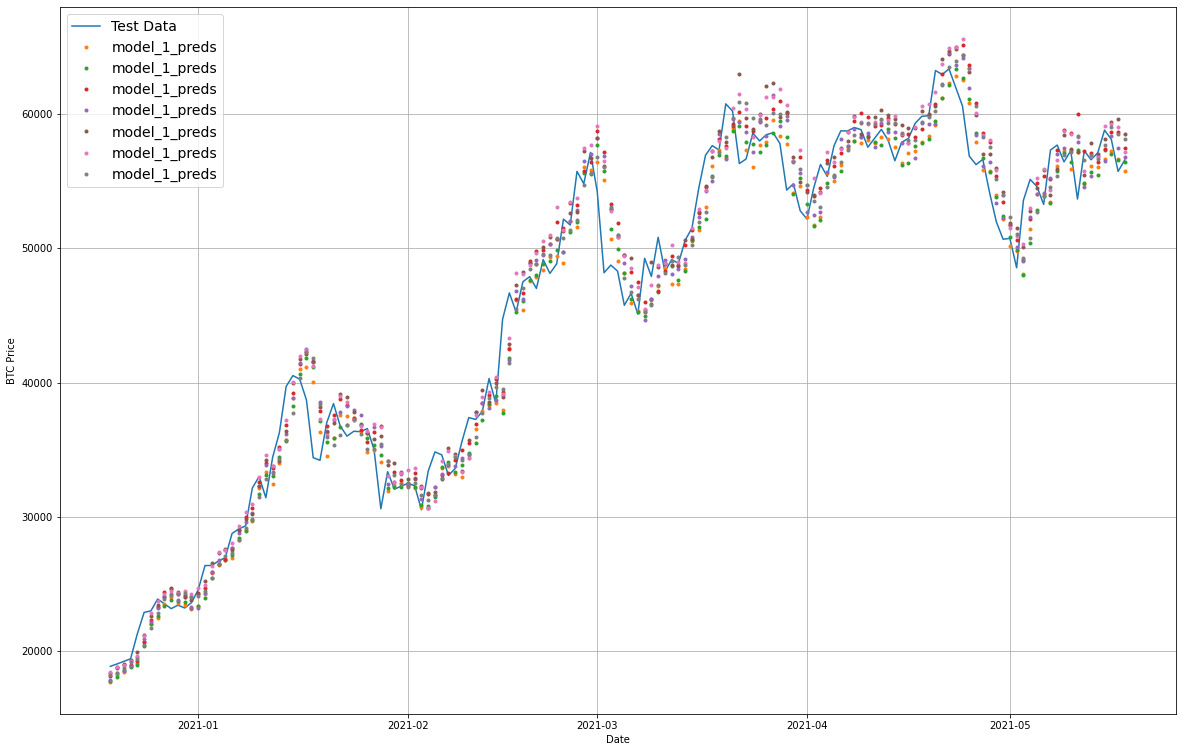

In [44]:
# Visualize predictions for better interpretation
offset = 400
plt.figure(figsize=(20, 13))
plot_time_series(timesteps=X_test[-len(test_labels):], values=test_labels[:, 0], start=offset, format='-', label='Test Data')
plot_time_series(timesteps=X_test[-len(test_labels):], values=model_1_preds, start=offset, label='model_1_preds' )

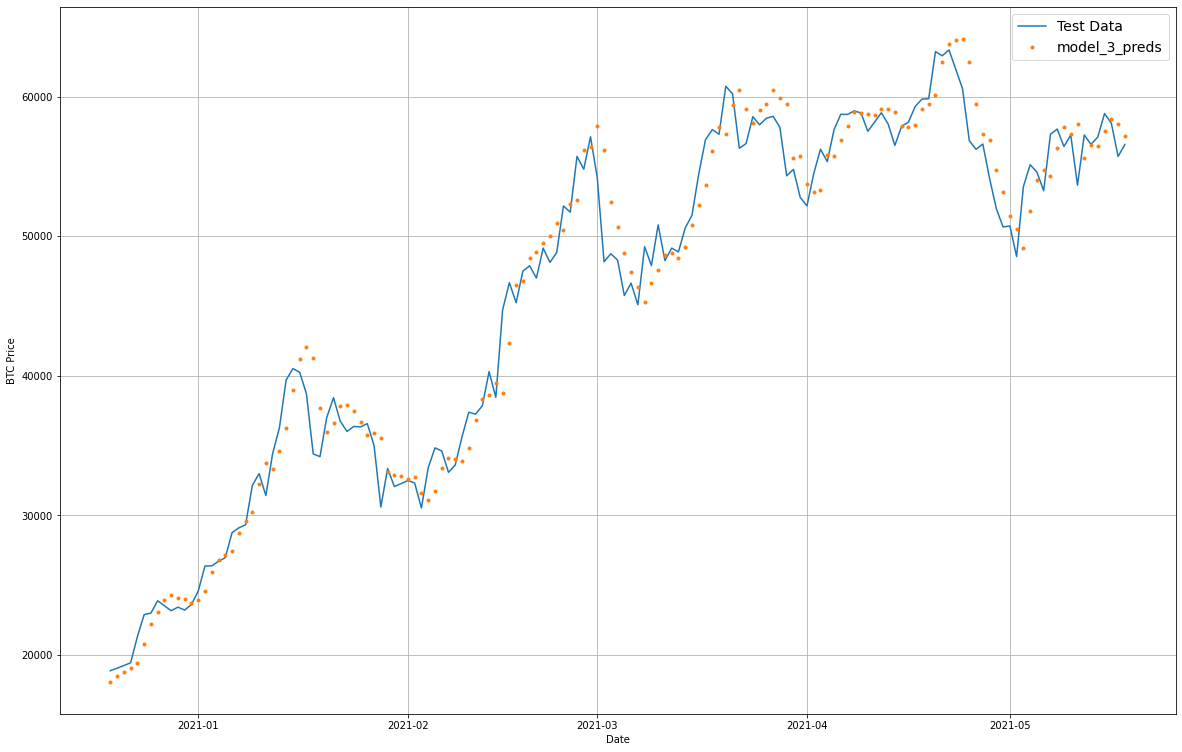

In [45]:
# Aggregate the 7-day predictions for visual interpretation (while loses information across multiple days)
offset = 400
plt.figure(figsize=(20, 13))
plot_time_series(timesteps=X_test[-len(test_labels):],
                 values=test_labels[:, 0],
                 start=offset,
                 format='-',
                 label='Test Data')
plot_time_series(timesteps=X_test[-len(test_labels):],
                 values=tf.reduce_mean(model_1_preds, axis=1),
                 start=offset,
                 label='model_3_preds')

## Convolutional 1D model
In this experiment, a window size of 7 and a horizon of 1 will be used for conv1D modelling.

In [46]:
# Specify parameters
HORIZON = 1
WINDOW_SIZE = 7

# Create windowed data
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)

# Create train/test splits
train_windows, test_windows, train_labels, test_labels = make_train_test_split(full_windows, full_labels)

len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

In [47]:
# Check data shape
train_windows[0].shape

(7,)

In [48]:
# Set seed for reproducibility
tf.random.set_seed(42)

# Create model
model_2 = tf.keras.Sequential([layers.Lambda(lambda x: tf.expand_dims(x, axis=1)), # resize the inputs for Conv1D 3D input requirements
                               layers.Conv1D(filters=128, kernel_size=5, padding='causal', activation='relu'),
                               layers.Dense(HORIZON)], name='model_2_conv1D')

# Compile model
model_2.compile(loss=tf.keras.losses.MeanAbsoluteError(),
                optimizer=tf.keras.optimizers.Adam())

# Fit model
model_2.fit(x=train_windows,
           y=train_labels,
           epochs=100,
           batch_size=128,
           validation_data=(test_windows, test_labels),
           callbacks=[create_model_checkpoint(model_name=model_2.name)])

Epoch 1/100
18/18 [==============================] - 10s 59ms/step - loss: 1207.3817 - val_loss: 2320.6218
Epoch 2/100
18/18 [==============================] - 1s 35ms/step - loss: 316.2171 - val_loss: 1467.2799
Epoch 3/100
18/18 [==============================] - 1s 46ms/step - loss: 192.6853 - val_loss: 1164.7074
Epoch 4/100
18/18 [==============================] - 1s 35ms/step - loss: 177.3535 - val_loss: 981.6695
Epoch 5/100
18/18 [==============================] - 1s 36ms/step - loss: 172.3467 - val_loss: 960.8708
Epoch 6/100
18/18 [==============================] - 1s 35ms/step - loss: 171.9753 - val_loss: 950.2026
Epoch 7/100
18/18 [==============================] - 1s 35ms/step - loss: 167.1943 - val_loss: 943.2872
Epoch 8/100
18/18 [==============================] - 1s 35ms/step - loss: 163.5990 - val_loss: 905.5262
Epoch 9/100
18/18 [==============================] - 0s 4ms/step - loss: 162.5455 - val_loss: 929.7607
Epoch 10/100
18/18 [==============================] - 1s 34m

In [49]:
# Get a view of the conv1D model
model_2.summary()

Model: "model_2_conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 1, 7)              0         
                                                                 
 conv1d (Conv1D)             (None, 1, 128)            4608      
                                                                 
 dense_2 (Dense)             (None, 1, 1)              129       
                                                                 
Total params: 4,737
Trainable params: 4,737
Non-trainable params: 0
_________________________________________________________________


In [50]:
# Load in the best version of the trained model and evaluate on test data
model_2 = tf.keras.models.load_model('/content/model_experiments/model_2_conv1D')
model_2.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 4ms/step - loss: 570.8284


570.828369140625

In [51]:
# Make predictions
model_2_preds = model_2.predict(test_windows)
model_2_preds = tf.squeeze(model_2_preds)
model_2_preds

<tf.Tensor: shape=(556,), dtype=float32, numpy=
array([ 8851.464 ,  8754.47  ,  8983.927 ,  8759.671 ,  8703.627 ,
        8708.294 ,  8661.667 ,  8494.839 ,  8435.316 ,  8492.114 ,
        8241.816 ,  8094.01  ,  8041.584 ,  7676.3667,  7297.379 ,
        7262.2935,  7077.191 ,  7150.1694,  7120.288 ,  7424.805 ,
        7419.5854,  7669.93  ,  7598.7695,  7421.4614,  7322.205 ,
        7297.68  ,  7209.786 ,  7326.6294,  7474.052 ,  7531.3774,
        7543.723 ,  7370.866 ,  7240.8843,  7177.49  ,  7165.149 ,
        7198.0557,  7088.27  ,  7079.028 ,  6902.333 ,  6615.6274,
        7217.2627,  7216.3306,  7145.9585,  7227.955 ,  7270.6016,
        7195.5254,  7191.2   ,  7209.8105,  7179.4697,  7197.0938,
        7284.108 ,  7370.0645,  7272.595 ,  7177.1064,  7154.7183,
        6977.8027,  7192.742 ,  7315.844 ,  7350.113 ,  7639.8657,
        8013.3135,  8125.8745,  7885.3916,  8039.662 ,  8107.902 ,
        8150.3164,  8108.7153,  8618.482 ,  8876.037 ,  8780.378 ,
        8894.8

In [52]:
# Evaluate predictions with various metrics
model_2_results = evaluate_preds(y_true=tf.squeeze(test_labels), y_pred=model_2_preds)
model_2_results

{'MAE': 570.82837,
 'MAPE': 2.5593357,
 'MASE': 1.0027874,
 'MSE': 1176671.2,
 'RMSE': 1084.7448}

## RNN (LSTM) model

In [53]:
# Set seed for reproducibility
tf.random.set_seed(42)

# Create model with Functional API
inputs = layers.Input(shape=(WINDOW_SIZE))
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs)
x = layers.LSTM(128, activation='relu')(x)
outputs = layers.Dense(HORIZON)(x)
model_3 = tf.keras.Model(inputs=inputs, outputs=outputs, name='model_3_LSTM')

# Compile model
model_3.compile(loss='mae',
                optimizer=tf.keras.optimizers.Adam())

# Fit model
model_3.fit(x=train_windows,
           y=train_labels,
           epochs=100,
           batch_size=128,
           validation_data=(test_windows, test_labels),
           callbacks=[create_model_checkpoint(model_name=model_3.name)])

Epoch 1/100
12/18 [===================>..........] - ETA: 0s - loss: 2534.5144 INFO:tensorflow:Assets written to: model_experiments/model_3_LSTM/assets


18/18 [==============================] - 3s 105ms/step - loss: 2323.6082 - val_loss: 9222.6523
Epoch 2/100
10/18 [===============>..............] - ETA: 0s - loss: 989.3721 INFO:tensorflow:Assets written to: model_experiments/model_3_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_LSTM/assets


18/18 [==============================] - 2s 94ms/step - loss: 695.4739 - val_loss: 1486.0555
Epoch 3/100
11/18 [=================>............] - ETA: 0s - loss: 270.4985INFO:tensorflow:Assets written to: model_experiments/model_3_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_LSTM/assets


18/18 [==============================] - 2s 112ms/step - loss: 237.3967 - val_loss: 1298.9084
Epoch 4/100
12/18 [===================>..........] - ETA: 0s - loss: 192.6114INFO:tensorflow:Assets written to: model_experiments/model_3_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_LSTM/assets


18/18 [==============================] - 2s 94ms/step - loss: 181.9180 - val_loss: 966.6431
Epoch 5/100
18/18 [==============================] - 0s 7ms/step - loss: 173.4022 - val_loss: 970.9295
Epoch 6/100
 9/18 [==============>...............] - ETA: 0s - loss: 168.0930INFO:tensorflow:Assets written to: model_experiments/model_3_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_LSTM/assets


18/18 [==============================] - 2s 94ms/step - loss: 173.5414 - val_loss: 941.4746
Epoch 7/100
12/18 [===================>..........] - ETA: 0s - loss: 177.6533INFO:tensorflow:Assets written to: model_experiments/model_3_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_LSTM/assets


18/18 [==============================] - 2s 94ms/step - loss: 170.3566 - val_loss: 898.5215
Epoch 8/100
18/18 [==============================] - 0s 7ms/step - loss: 157.6712 - val_loss: 914.8642
Epoch 9/100
18/18 [==============================] - 0s 6ms/step - loss: 166.5143 - val_loss: 1079.0776
Epoch 10/100
13/18 [====================>.........] - ETA: 0s - loss: 160.3262INFO:tensorflow:Assets written to: model_experiments/model_3_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_LSTM/assets


18/18 [==============================] - 2s 112ms/step - loss: 162.3369 - val_loss: 877.1690
Epoch 11/100
18/18 [==============================] - 0s 7ms/step - loss: 163.0841 - val_loss: 924.1126
Epoch 12/100
18/18 [==============================] - 0s 6ms/step - loss: 168.5598 - val_loss: 941.6025
Epoch 13/100
18/18 [==============================] - 0s 7ms/step - loss: 166.4726 - val_loss: 934.8436
Epoch 14/100
18/18 [==============================] - 0s 7ms/step - loss: 163.9537 - val_loss: 920.2160
Epoch 15/100
18/18 [==============================] - ETA: 0s - loss: 152.9470INFO:tensorflow:Assets written to: model_experiments/model_3_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_LSTM/assets


18/18 [==============================] - 2s 96ms/step - loss: 152.9470 - val_loss: 856.2653
Epoch 16/100
18/18 [==============================] - 0s 6ms/step - loss: 147.4420 - val_loss: 898.9914
Epoch 17/100
18/18 [==============================] - 0s 6ms/step - loss: 151.0533 - val_loss: 943.1418
Epoch 18/100
18/18 [==============================] - 0s 6ms/step - loss: 157.8232 - val_loss: 924.0046
Epoch 19/100
18/18 [==============================] - 0s 8ms/step - loss: 155.9198 - val_loss: 911.4753
Epoch 20/100
18/18 [==============================] - 0s 7ms/step - loss: 155.6456 - val_loss: 862.6680
Epoch 21/100
18/18 [==============================] - 0s 7ms/step - loss: 153.1514 - val_loss: 862.5831
Epoch 22/100
18/18 [==============================] - 0s 7ms/step - loss: 151.4883 - val_loss: 863.8172
Epoch 23/100
18/18 [==============================] - 0s 7ms/step - loss: 150.7770 - val_loss: 886.8356
Epoch 24/100
18/18 [==============================] - 0s 6ms/step - loss: 14

INFO:tensorflow:Assets written to: model_experiments/model_3_LSTM/assets


18/18 [==============================] - 2s 95ms/step - loss: 146.8467 - val_loss: 845.2782
Epoch 26/100
12/18 [===================>..........] - ETA: 0s - loss: 146.2229INFO:tensorflow:Assets written to: model_experiments/model_3_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_LSTM/assets


18/18 [==============================] - 2s 110ms/step - loss: 145.9843 - val_loss: 818.6807
Epoch 27/100
11/18 [=================>............] - ETA: 0s - loss: 153.2509INFO:tensorflow:Assets written to: model_experiments/model_3_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_LSTM/assets


18/18 [==============================] - 2s 94ms/step - loss: 144.4289 - val_loss: 804.3279
Epoch 28/100
12/18 [===================>..........] - ETA: 0s - loss: 142.2844INFO:tensorflow:Assets written to: model_experiments/model_3_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_LSTM/assets


18/18 [==============================] - 2s 94ms/step - loss: 142.4610 - val_loss: 789.0859
Epoch 29/100
18/18 [==============================] - 0s 7ms/step - loss: 141.8739 - val_loss: 806.6758
Epoch 30/100
18/18 [==============================] - 0s 7ms/step - loss: 142.0521 - val_loss: 794.8836
Epoch 31/100
12/18 [===================>..........] - ETA: 0s - loss: 140.2585INFO:tensorflow:Assets written to: model_experiments/model_3_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_LSTM/assets


18/18 [==============================] - 2s 113ms/step - loss: 138.4690 - val_loss: 773.2812
Epoch 32/100
11/18 [=================>............] - ETA: 0s - loss: 137.6196INFO:tensorflow:Assets written to: model_experiments/model_3_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_LSTM/assets


18/18 [==============================] - 2s 95ms/step - loss: 137.1986 - val_loss: 772.2625
Epoch 33/100
18/18 [==============================] - 0s 7ms/step - loss: 135.9342 - val_loss: 786.4805
Epoch 34/100
12/18 [===================>..........] - ETA: 0s - loss: 142.0684INFO:tensorflow:Assets written to: model_experiments/model_3_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_LSTM/assets


18/18 [==============================] - 2s 94ms/step - loss: 136.1931 - val_loss: 744.4506
Epoch 35/100
18/18 [==============================] - 0s 7ms/step - loss: 133.4513 - val_loss: 756.2970
Epoch 36/100
 9/18 [==============>...............] - ETA: 0s - loss: 129.2968INFO:tensorflow:Assets written to: model_experiments/model_3_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_LSTM/assets


18/18 [==============================] - 2s 133ms/step - loss: 134.0992 - val_loss: 735.1729
Epoch 37/100
18/18 [==============================] - 0s 6ms/step - loss: 130.6932 - val_loss: 745.9099
Epoch 38/100
11/18 [=================>............] - ETA: 0s - loss: 138.3565INFO:tensorflow:Assets written to: model_experiments/model_3_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_LSTM/assets


18/18 [==============================] - 2s 116ms/step - loss: 129.2891 - val_loss: 717.2498
Epoch 39/100
18/18 [==============================] - 0s 7ms/step - loss: 129.6088 - val_loss: 719.0665
Epoch 40/100
18/18 [==============================] - 0s 7ms/step - loss: 129.6111 - val_loss: 732.0632
Epoch 41/100
12/18 [===================>..........] - ETA: 0s - loss: 130.4034INFO:tensorflow:Assets written to: model_experiments/model_3_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_LSTM/assets


18/18 [==============================] - 2s 95ms/step - loss: 127.1393 - val_loss: 702.9354
Epoch 42/100
11/18 [=================>............] - ETA: 0s - loss: 126.7599INFO:tensorflow:Assets written to: model_experiments/model_3_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_LSTM/assets


18/18 [==============================] - 2s 95ms/step - loss: 125.6113 - val_loss: 700.8702
Epoch 43/100
18/18 [==============================] - 0s 6ms/step - loss: 125.9959 - val_loss: 704.3682
Epoch 44/100
12/18 [===================>..........] - ETA: 0s - loss: 124.8729INFO:tensorflow:Assets written to: model_experiments/model_3_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_LSTM/assets


18/18 [==============================] - 2s 111ms/step - loss: 125.2241 - val_loss: 698.7766
Epoch 45/100
11/18 [=================>............] - ETA: 0s - loss: 121.2221INFO:tensorflow:Assets written to: model_experiments/model_3_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_LSTM/assets


18/18 [==============================] - 3s 170ms/step - loss: 122.5007 - val_loss: 683.0590
Epoch 46/100
11/18 [=================>............] - ETA: 0s - loss: 130.6197INFO:tensorflow:Assets written to: model_experiments/model_3_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_LSTM/assets


18/18 [==============================] - 2s 96ms/step - loss: 124.4726 - val_loss: 679.1873
Epoch 47/100
18/18 [==============================] - 0s 7ms/step - loss: 122.1862 - val_loss: 705.4241
Epoch 48/100
12/18 [===================>..........] - ETA: 0s - loss: 119.4245INFO:tensorflow:Assets written to: model_experiments/model_3_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_LSTM/assets


18/18 [==============================] - 2s 94ms/step - loss: 122.0458 - val_loss: 677.0784
Epoch 49/100
12/18 [===================>..........] - ETA: 0s - loss: 126.2884INFO:tensorflow:Assets written to: model_experiments/model_3_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_LSTM/assets


18/18 [==============================] - 2s 115ms/step - loss: 121.1548 - val_loss: 674.6848
Epoch 50/100
18/18 [==============================] - 0s 7ms/step - loss: 122.8890 - val_loss: 691.4816
Epoch 51/100
18/18 [==============================] - 0s 8ms/step - loss: 122.2994 - val_loss: 737.3929
Epoch 52/100
12/18 [===================>..........] - ETA: 0s - loss: 129.3352INFO:tensorflow:Assets written to: model_experiments/model_3_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_LSTM/assets


18/18 [==============================] - 2s 96ms/step - loss: 121.2944 - val_loss: 657.2365
Epoch 53/100
12/18 [===================>..........] - ETA: 0s - loss: 116.8399INFO:tensorflow:Assets written to: model_experiments/model_3_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_LSTM/assets


18/18 [==============================] - 2s 94ms/step - loss: 119.7668 - val_loss: 652.7970
Epoch 54/100
18/18 [==============================] - 0s 6ms/step - loss: 120.1222 - val_loss: 654.4439
Epoch 55/100
12/18 [===================>..........] - ETA: 0s - loss: 125.5305INFO:tensorflow:Assets written to: model_experiments/model_3_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_LSTM/assets


18/18 [==============================] - 2s 112ms/step - loss: 119.2566 - val_loss: 647.2831
Epoch 56/100
11/18 [=================>............] - ETA: 0s - loss: 122.4764INFO:tensorflow:Assets written to: model_experiments/model_3_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_LSTM/assets


18/18 [==============================] - 2s 95ms/step - loss: 120.0544 - val_loss: 643.7808
Epoch 57/100
18/18 [==============================] - 0s 7ms/step - loss: 123.1243 - val_loss: 671.1797
Epoch 58/100
12/18 [===================>..........] - ETA: 0s - loss: 118.0024INFO:tensorflow:Assets written to: model_experiments/model_3_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_LSTM/assets


18/18 [==============================] - 2s 97ms/step - loss: 118.4059 - val_loss: 640.2656
Epoch 59/100
18/18 [==============================] - 0s 7ms/step - loss: 117.7119 - val_loss: 645.3837
Epoch 60/100
11/18 [=================>............] - ETA: 0s - loss: 119.2167INFO:tensorflow:Assets written to: model_experiments/model_3_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_LSTM/assets


18/18 [==============================] - 2s 96ms/step - loss: 118.5346 - val_loss: 638.7429
Epoch 61/100
18/18 [==============================] - 0s 6ms/step - loss: 118.3129 - val_loss: 689.4144
Epoch 62/100
18/18 [==============================] - 0s 7ms/step - loss: 121.4350 - val_loss: 748.5565
Epoch 63/100
18/18 [==============================] - 0s 7ms/step - loss: 123.1006 - val_loss: 651.8298
Epoch 64/100
18/18 [==============================] - 0s 7ms/step - loss: 115.9679 - val_loss: 672.9166
Epoch 65/100
 9/18 [==============>...............] - ETA: 0s - loss: 120.0782INFO:tensorflow:Assets written to: model_experiments/model_3_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_LSTM/assets


18/18 [==============================] - 2s 114ms/step - loss: 118.8341 - val_loss: 631.7538
Epoch 66/100
18/18 [==============================] - 0s 7ms/step - loss: 116.2212 - val_loss: 634.5445
Epoch 67/100
11/18 [=================>............] - ETA: 0s - loss: 116.1731INFO:tensorflow:Assets written to: model_experiments/model_3_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_LSTM/assets


18/18 [==============================] - 2s 95ms/step - loss: 116.1580 - val_loss: 623.8932
Epoch 68/100
18/18 [==============================] - 0s 7ms/step - loss: 115.5543 - val_loss: 635.4929
Epoch 69/100
18/18 [==============================] - 0s 6ms/step - loss: 120.5866 - val_loss: 626.3387
Epoch 70/100
12/18 [===================>..........] - ETA: 0s - loss: 111.8156INFO:tensorflow:Assets written to: model_experiments/model_3_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_LSTM/assets


18/18 [==============================] - 2s 96ms/step - loss: 114.9188 - val_loss: 619.3181
Epoch 71/100
18/18 [==============================] - 0s 7ms/step - loss: 114.8998 - val_loss: 650.9373
Epoch 72/100
18/18 [==============================] - 0s 7ms/step - loss: 118.2033 - val_loss: 630.5287
Epoch 73/100
18/18 [==============================] - 0s 6ms/step - loss: 115.3612 - val_loss: 623.0369
Epoch 74/100
18/18 [==============================] - 0s 7ms/step - loss: 115.0345 - val_loss: 623.0776
Epoch 75/100
18/18 [==============================] - 0s 7ms/step - loss: 115.2057 - val_loss: 640.5281
Epoch 76/100
11/18 [=================>............] - ETA: 0s - loss: 114.5117INFO:tensorflow:Assets written to: model_experiments/model_3_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_LSTM/assets


18/18 [==============================] - 2s 112ms/step - loss: 114.1402 - val_loss: 614.4062
Epoch 77/100
18/18 [==============================] - 0s 7ms/step - loss: 115.5973 - val_loss: 689.8776
Epoch 78/100
18/18 [==============================] - 0s 7ms/step - loss: 117.2611 - val_loss: 645.2790
Epoch 79/100
 9/18 [==============>...............] - ETA: 0s - loss: 109.2401INFO:tensorflow:Assets written to: model_experiments/model_3_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_LSTM/assets


18/18 [==============================] - 2s 96ms/step - loss: 114.1995 - val_loss: 608.7159
Epoch 80/100
18/18 [==============================] - 0s 7ms/step - loss: 112.7125 - val_loss: 614.9222
Epoch 81/100
18/18 [==============================] - 0s 8ms/step - loss: 113.3684 - val_loss: 634.8466
Epoch 82/100
12/18 [===================>..........] - ETA: 0s - loss: 120.5586INFO:tensorflow:Assets written to: model_experiments/model_3_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_LSTM/assets


18/18 [==============================] - 2s 95ms/step - loss: 115.9701 - val_loss: 607.8510
Epoch 83/100
18/18 [==============================] - 0s 6ms/step - loss: 113.3599 - val_loss: 628.8181
Epoch 84/100
18/18 [==============================] - 0s 7ms/step - loss: 114.4113 - val_loss: 628.5579
Epoch 85/100
18/18 [==============================] - 0s 7ms/step - loss: 114.8363 - val_loss: 634.7715
Epoch 86/100
18/18 [==============================] - 0s 8ms/step - loss: 115.5462 - val_loss: 613.5223
Epoch 87/100
12/18 [===================>..........] - ETA: 0s - loss: 115.3621INFO:tensorflow:Assets written to: model_experiments/model_3_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_LSTM/assets


18/18 [==============================] - 2s 94ms/step - loss: 112.5059 - val_loss: 604.7603
Epoch 88/100
12/18 [===================>..........] - ETA: 0s - loss: 115.3784INFO:tensorflow:Assets written to: model_experiments/model_3_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_LSTM/assets


18/18 [==============================] - 2s 114ms/step - loss: 111.7706 - val_loss: 601.5748
Epoch 89/100
18/18 [==============================] - 0s 7ms/step - loss: 111.8470 - val_loss: 624.0131
Epoch 90/100
18/18 [==============================] - 0s 8ms/step - loss: 115.6354 - val_loss: 662.9452
Epoch 91/100
18/18 [==============================] - 0s 7ms/step - loss: 116.1836 - val_loss: 636.0310
Epoch 92/100
18/18 [==============================] - 0s 6ms/step - loss: 113.1700 - val_loss: 606.0366
Epoch 93/100
11/18 [=================>............] - ETA: 0s - loss: 113.7486INFO:tensorflow:Assets written to: model_experiments/model_3_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_LSTM/assets


18/18 [==============================] - 2s 94ms/step - loss: 112.4748 - val_loss: 599.8319
Epoch 94/100
18/18 [==============================] - 0s 8ms/step - loss: 111.2637 - val_loss: 601.3256
Epoch 95/100
11/18 [=================>............] - ETA: 0s - loss: 106.7242INFO:tensorflow:Assets written to: model_experiments/model_3_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_LSTM/assets


18/18 [==============================] - 2s 95ms/step - loss: 111.0185 - val_loss: 597.1485
Epoch 96/100
18/18 [==============================] - 0s 6ms/step - loss: 112.3787 - val_loss: 601.1596
Epoch 97/100
18/18 [==============================] - 0s 7ms/step - loss: 111.4700 - val_loss: 626.1573
Epoch 98/100
18/18 [==============================] - 0s 7ms/step - loss: 111.7326 - val_loss: 601.0142
Epoch 99/100
12/18 [===================>..........] - ETA: 0s - loss: 109.4926INFO:tensorflow:Assets written to: model_experiments/model_3_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_LSTM/assets


18/18 [==============================] - 2s 112ms/step - loss: 110.7480 - val_loss: 594.6030
Epoch 100/100
18/18 [==============================] - 0s 7ms/step - loss: 111.9943 - val_loss: 595.9847


In [54]:
# Load in best version of the trained LSTM model and evaluate on test data
model_3 = tf.keras.models.load_model('/content/model_experiments/model_3_LSTM')
model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 594.6030


594.6029663085938

In [55]:
# Make predictions
model_3_preds = model_3.predict(test_windows)
model_3_preds = tf.squeeze(model_3_preds)
model_3_preds

<tf.Tensor: shape=(556,), dtype=float32, numpy=
array([ 8978.46  ,  8810.951 ,  8997.779 ,  8836.308 ,  8731.047 ,
        8776.852 ,  8733.2   ,  8541.157 ,  8503.402 ,  8531.719 ,
        8324.289 ,  8151.923 ,  8099.21  ,  7778.159 ,  7351.918 ,
        7276.387 ,  7113.1914,  7112.851 ,  7140.525 ,  7420.634 ,
        7440.0205,  7670.7964,  7636.9453,  7504.4717,  7364.8438,
        7366.5273,  7243.8267,  7339.6807,  7491.5435,  7553.0063,
        7570.0845,  7452.971 ,  7305.3716,  7228.7847,  7205.409 ,
        7217.7637,  7147.0293,  7121.6133,  6976.0654,  6699.7153,
        7145.1777,  7255.7427,  7157.815 ,  7250.904 ,  7357.0483,
        7192.958 ,  7236.739 ,  7256.082 ,  7211.879 ,  7230.1206,
        7313.7344,  7385.461 ,  7321.7725,  7235.3594,  7205.8477,
        7050.1113,  7184.835 ,  7334.523 ,  7372.5376,  7611.1377,
        8002.8906,  8112.347 ,  7948.056 ,  8072.672 ,  8141.408 ,
        8158.7534,  8138.0874,  8592.4795,  8849.767 ,  8815.69  ,
        8908.5

In [56]:
# Evaluate predictions with various metrics
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels), y_pred=model_3_preds)
model_3_results

{'MAE': 594.60297,
 'MAPE': 2.6717565,
 'MASE': 1.0445527,
 'MSE': 1267231.9,
 'RMSE': 1125.7139}

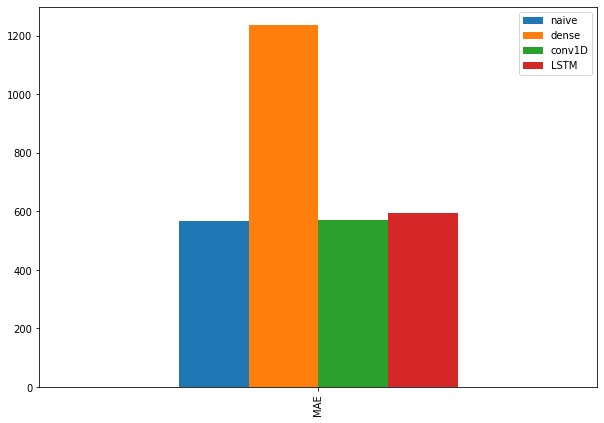

In [57]:
# Compare the model's performance of different experiments
pd.DataFrame({'naive': naive_results['MAE'],
              'dense': model_1_results['MAE'],
              'conv1D': model_2_results['MAE'],
              'LSTM': model_3_results['MAE']}, index=['MAE']).plot(figsize=(10, 7), kind='bar')

## Dense model (multivariate data)
Add an extra feature (Bitcoin block reward size) to dataset to take data from **univariate** (only the historicaly price of Bitcoin) to **multivariate** (the price of Bitcoin as well as the block reward size).

### Create multivariate data

In [58]:
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


In [59]:
# Add Bitcoin halving events to dataset
block_reward_1 = 50        # 2009/01/03
block_reward_2 = 25        # 2012/11/28
block_reward_3 = 12.5      # 2016/07/09
block_reward_4 = 6.25      # 2020/05/18

# Assign block reward date
block_reward_3_date = np.datetime64('2016-07-09')
block_reward_4_date = np.datetime64('2020-05-18')

# Get date indexes for when to add in different block dates
block_reward_2_days = (block_reward_3_date - bitcoin_prices.index[0]).days
block_reward_3_days = (block_reward_4_date - bitcoin_prices.index[0]).days

# Add block reward column
bitcoin_prices_block = bitcoin_prices.copy()
bitcoin_prices_block['block_reward'] = None

# Set block reward values
bitcoin_prices_block.iloc[:block_reward_2_days, -1] = block_reward_2
bitcoin_prices_block.iloc[block_reward_2_days:block_reward_3_days, -1] = block_reward_3
bitcoin_prices_block.iloc[block_reward_3_days:, -1] = block_reward_4
bitcoin_prices_block

,Price,block_reward
Date,,
2013-10-01,123.654990,25
2013-10-02,125.455000,25
2013-10-03,108.584830,25
2013-10-04,118.674660,25
2013-10-05,121.338660,25
...,...,...
2021-05-14,49764.132082,6.25
2021-05-15,50032.693137,6.25
2021-05-16,47885.625255,6.25


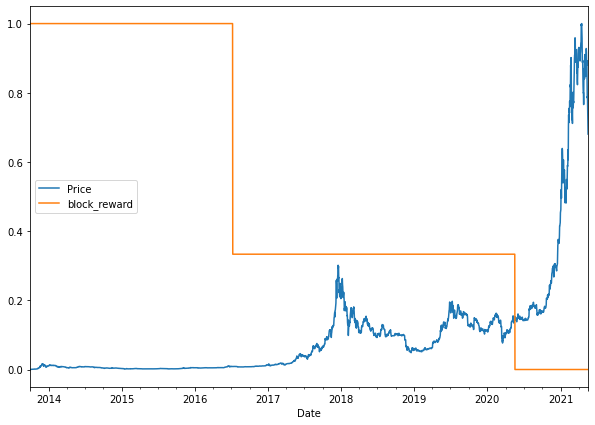

In [60]:
# Plot the block reward/price over time
# Scale different scale of values to be between 0 and 1
scaled_price_block_df = pd.DataFrame(minmax_scale(bitcoin_prices_block[['Price', 'block_reward']]),
                                     columns=bitcoin_prices_block.columns,
                                     index=bitcoin_prices_block.index)
scaled_price_block_df.plot(figsize=(10, 7))

### Make windowed dataset with Pandas

In [61]:
# Setup dataset hyperparameters
HORIZON = 1
WINDOW_SIZE = 7

# Make a copy of data
bitcoin_prices_windowed = bitcoin_prices_block.copy()

# Add windowed columns
for i in range(WINDOW_SIZE):
  bitcoin_prices_windowed[f'Price+{i+1}'] = bitcoin_prices_windowed['Price'].shift(periods=i+1)
bitcoin_prices_windowed.head(10)

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2013-10-01,123.65499,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,25,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,25,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,25,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,25,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN
2013-10-06,120.65533,25,121.33866,118.67466,108.58483,125.45500,123.65499,NaN,NaN
2013-10-07,121.79500,25,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499,NaN
2013-10-08,123.03300,25,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499
2013-10-09,124.04900,25,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500


In [62]:
# Separate data and labels
X = bitcoin_prices_windowed.dropna().drop('Price', axis=1).astype(np.float32)
y = bitcoin_prices_windowed.dropna()['Price'].astype(np.float32)

X.head()

,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-10-08,25.0,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002,123.654991
2013-10-09,25.0,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002
2013-10-10,25.0,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831
2013-10-11,25.0,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660
2013-10-12,25.0,125.279663,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661


In [63]:
y.head()

Date
2013-10-08    123.032997
2013-10-09    124.049004
2013-10-10    125.961159
2013-10-11    125.279663
2013-10-12    125.927498
Name: Price, dtype: float32

### Train_test_split

In [64]:
# Make train and test sets
split_size = int(len(X) * 0.8)

X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]

len(X_train), len(y_train), len(X_test), len(y_test)

(2224, 2224, 556, 556)

### Sense model with multivariate time series

In [65]:
# Set seed for reproducible results
tf.random.set_seed(42)

# Construct model
model_4 = tf.keras.Sequential([layers.Dense(128, activation='relu'),
                               layers.Dense(HORIZON)], name='model_4_dense_multivariate')

# Compile model
model_4.compile(loss=tf.keras.losses.MeanAbsoluteError(),
                optimizer=tf.keras.optimizers.Adam())

# Fit model
model_4.fit(X_train,
           y_train,
           batch_size=128,
           epochs=100,
           validation_data=(X_test, y_test),
           callbacks=[create_model_checkpoint(model_name=model_4.name)])

Epoch 1/100
 1/18 [>.............................] - ETA: 4s - loss: 2853.4023INFO:tensorflow:Assets written to: model_experiments/model_4_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_dense_multivariate/assets


18/18 [==============================] - 1s 31ms/step - loss: 1234.6804 - val_loss: 2061.9077
Epoch 2/100
 1/18 [>.............................] - ETA: 0s - loss: 337.7052INFO:tensorflow:Assets written to: model_experiments/model_4_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_dense_multivariate/assets


18/18 [==============================] - 0s 25ms/step - loss: 351.5053 - val_loss: 1908.6733
Epoch 3/100
 1/18 [>.............................] - ETA: 0s - loss: 249.1732INFO:tensorflow:Assets written to: model_experiments/model_4_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_dense_multivariate/assets


18/18 [==============================] - 0s 25ms/step - loss: 235.4153 - val_loss: 1329.0585
Epoch 4/100
 1/18 [>.............................] - ETA: 0s - loss: 271.0341INFO:tensorflow:Assets written to: model_experiments/model_4_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_dense_multivariate/assets


18/18 [==============================] - 0s 25ms/step - loss: 208.6112 - val_loss: 1102.1342
Epoch 5/100
18/18 [==============================] - 0s 5ms/step - loss: 196.5770 - val_loss: 1107.8474
Epoch 6/100
 1/18 [>.............................] - ETA: 0s - loss: 145.3367INFO:tensorflow:Assets written to: model_experiments/model_4_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_dense_multivariate/assets


18/18 [==============================] - 0s 24ms/step - loss: 187.2245 - val_loss: 1036.1720
Epoch 7/100
 1/18 [>.............................] - ETA: 0s - loss: 231.5105INFO:tensorflow:Assets written to: model_experiments/model_4_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_dense_multivariate/assets


18/18 [==============================] - 0s 25ms/step - loss: 182.0245 - val_loss: 1019.2928
Epoch 8/100
 1/18 [>.............................] - ETA: 0s - loss: 151.5176INFO:tensorflow:Assets written to: model_experiments/model_4_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_dense_multivariate/assets


18/18 [==============================] - 0s 25ms/step - loss: 175.7059 - val_loss: 977.8488
Epoch 9/100
 1/18 [>.............................] - ETA: 0s - loss: 142.1689INFO:tensorflow:Assets written to: model_experiments/model_4_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_dense_multivariate/assets


18/18 [==============================] - 0s 24ms/step - loss: 170.1784 - val_loss: 954.4037
Epoch 10/100
 1/18 [>.............................] - ETA: 0s - loss: 177.8448INFO:tensorflow:Assets written to: model_experiments/model_4_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_dense_multivariate/assets


18/18 [==============================] - 0s 24ms/step - loss: 164.4430 - val_loss: 913.5148
Epoch 11/100
 1/18 [>.............................] - ETA: 0s - loss: 171.3627INFO:tensorflow:Assets written to: model_experiments/model_4_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_dense_multivariate/assets


18/18 [==============================] - 1s 40ms/step - loss: 158.6892 - val_loss: 874.2507
Epoch 12/100
 1/18 [>.............................] - ETA: 0s - loss: 147.0429INFO:tensorflow:Assets written to: model_experiments/model_4_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_dense_multivariate/assets


18/18 [==============================] - 0s 24ms/step - loss: 152.0732 - val_loss: 861.0418
Epoch 13/100
18/18 [==============================] - 0s 4ms/step - loss: 151.1057 - val_loss: 886.1207
Epoch 14/100
 1/18 [>.............................] - ETA: 0s - loss: 152.2400INFO:tensorflow:Assets written to: model_experiments/model_4_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_dense_multivariate/assets


18/18 [==============================] - 0s 24ms/step - loss: 147.5482 - val_loss: 837.8616
Epoch 15/100
 1/18 [>.............................] - ETA: 0s - loss: 146.6370INFO:tensorflow:Assets written to: model_experiments/model_4_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_dense_multivariate/assets


18/18 [==============================] - 0s 24ms/step - loss: 142.3497 - val_loss: 794.4788
Epoch 16/100
 1/18 [>.............................] - ETA: 0s - loss: 125.8471INFO:tensorflow:Assets written to: model_experiments/model_4_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_dense_multivariate/assets


18/18 [==============================] - 0s 25ms/step - loss: 137.5206 - val_loss: 778.4052
Epoch 17/100
 1/18 [>.............................] - ETA: 0s - loss: 125.1490INFO:tensorflow:Assets written to: model_experiments/model_4_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_dense_multivariate/assets


18/18 [==============================] - 0s 25ms/step - loss: 135.8190 - val_loss: 772.4532
Epoch 18/100
 1/18 [>.............................] - ETA: 0s - loss: 145.6097INFO:tensorflow:Assets written to: model_experiments/model_4_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_dense_multivariate/assets


18/18 [==============================] - 0s 25ms/step - loss: 134.8562 - val_loss: 747.4802
Epoch 19/100
18/18 [==============================] - 0s 5ms/step - loss: 130.3347 - val_loss: 761.0554
Epoch 20/100
 1/18 [>.............................] - ETA: 0s - loss: 145.2515INFO:tensorflow:Assets written to: model_experiments/model_4_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_dense_multivariate/assets


18/18 [==============================] - 0s 27ms/step - loss: 128.6775 - val_loss: 701.8977
Epoch 21/100
 1/18 [>.............................] - ETA: 0s - loss: 158.9073INFO:tensorflow:Assets written to: model_experiments/model_4_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_dense_multivariate/assets


18/18 [==============================] - 0s 25ms/step - loss: 129.5576 - val_loss: 691.0128
Epoch 22/100
 1/18 [>.............................] - ETA: 0s - loss: 176.6308INFO:tensorflow:Assets written to: model_experiments/model_4_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_dense_multivariate/assets


18/18 [==============================] - 0s 24ms/step - loss: 125.8060 - val_loss: 684.4119
Epoch 23/100
18/18 [==============================] - 0s 4ms/step - loss: 125.5263 - val_loss: 692.1298
Epoch 24/100
 1/18 [>.............................] - ETA: 0s - loss: 134.1221INFO:tensorflow:Assets written to: model_experiments/model_4_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_dense_multivariate/assets


18/18 [==============================] - 0s 24ms/step - loss: 122.4765 - val_loss: 674.2216
Epoch 25/100
 1/18 [>.............................] - ETA: 0s - loss: 133.5674INFO:tensorflow:Assets written to: model_experiments/model_4_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_dense_multivariate/assets


18/18 [==============================] - 0s 24ms/step - loss: 121.1171 - val_loss: 669.6441
Epoch 26/100
18/18 [==============================] - 0s 4ms/step - loss: 127.2623 - val_loss: 690.0403
Epoch 27/100
 1/18 [>.............................] - ETA: 0s - loss: 180.3230INFO:tensorflow:Assets written to: model_experiments/model_4_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_dense_multivariate/assets


18/18 [==============================] - 0s 24ms/step - loss: 124.6204 - val_loss: 643.9724
Epoch 28/100
18/18 [==============================] - 0s 4ms/step - loss: 118.2544 - val_loss: 656.2767
Epoch 29/100
 1/18 [>.............................] - ETA: 0s - loss: 109.8149INFO:tensorflow:Assets written to: model_experiments/model_4_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_dense_multivariate/assets


18/18 [==============================] - 0s 25ms/step - loss: 119.6374 - val_loss: 633.4547
Epoch 30/100
 1/18 [>.............................] - ETA: 0s - loss: 130.2605INFO:tensorflow:Assets written to: model_experiments/model_4_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_dense_multivariate/assets


18/18 [==============================] - 0s 24ms/step - loss: 119.5001 - val_loss: 625.3953
Epoch 31/100
18/18 [==============================] - 0s 4ms/step - loss: 114.5633 - val_loss: 668.5064
Epoch 32/100
 1/18 [>.............................] - ETA: 0s - loss: 121.3793INFO:tensorflow:Assets written to: model_experiments/model_4_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_dense_multivariate/assets


18/18 [==============================] - 0s 25ms/step - loss: 116.9750 - val_loss: 617.1061
Epoch 33/100
18/18 [==============================] - 0s 4ms/step - loss: 115.2438 - val_loss: 649.0989
Epoch 34/100
18/18 [==============================] - 0s 4ms/step - loss: 114.5187 - val_loss: 632.1375
Epoch 35/100
 1/18 [>.............................] - ETA: 0s - loss: 112.6759INFO:tensorflow:Assets written to: model_experiments/model_4_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_dense_multivariate/assets


18/18 [==============================] - 0s 25ms/step - loss: 113.6357 - val_loss: 607.4173
Epoch 36/100
18/18 [==============================] - 0s 4ms/step - loss: 115.2605 - val_loss: 626.4319
Epoch 37/100
 1/18 [>.............................] - ETA: 0s - loss: 141.7286INFO:tensorflow:Assets written to: model_experiments/model_4_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_dense_multivariate/assets


18/18 [==============================] - 0s 24ms/step - loss: 113.7020 - val_loss: 606.2318
Epoch 38/100
 1/18 [>.............................] - ETA: 0s - loss: 107.1735INFO:tensorflow:Assets written to: model_experiments/model_4_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_dense_multivariate/assets


18/18 [==============================] - 0s 24ms/step - loss: 111.4061 - val_loss: 603.2919
Epoch 39/100
 1/18 [>.............................] - ETA: 0s - loss: 127.4214INFO:tensorflow:Assets written to: model_experiments/model_4_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_dense_multivariate/assets


18/18 [==============================] - 0s 25ms/step - loss: 112.7722 - val_loss: 596.0060
Epoch 40/100
 1/18 [>.............................] - ETA: 0s - loss: 100.2578INFO:tensorflow:Assets written to: model_experiments/model_4_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_dense_multivariate/assets


18/18 [==============================] - 0s 23ms/step - loss: 110.5418 - val_loss: 593.2170
Epoch 41/100
18/18 [==============================] - 0s 4ms/step - loss: 110.8671 - val_loss: 609.1062
Epoch 42/100
18/18 [==============================] - 0s 3ms/step - loss: 115.7249 - val_loss: 607.4877
Epoch 43/100
18/18 [==============================] - 0s 4ms/step - loss: 111.3313 - val_loss: 606.2029
Epoch 44/100
 1/18 [>.............................] - ETA: 0s - loss: 65.3244INFO:tensorflow:Assets written to: model_experiments/model_4_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_dense_multivariate/assets


18/18 [==============================] - 1s 40ms/step - loss: 109.7027 - val_loss: 586.1215
Epoch 45/100
18/18 [==============================] - 0s 4ms/step - loss: 107.8748 - val_loss: 593.8445
Epoch 46/100
18/18 [==============================] - 0s 3ms/step - loss: 109.8641 - val_loss: 586.4581
Epoch 47/100
18/18 [==============================] - 0s 4ms/step - loss: 112.3587 - val_loss: 655.4489
Epoch 48/100
18/18 [==============================] - 0s 4ms/step - loss: 109.1614 - val_loss: 598.7234
Epoch 49/100
18/18 [==============================] - 0s 4ms/step - loss: 109.3029 - val_loss: 589.2489
Epoch 50/100
18/18 [==============================] - 0s 5ms/step - loss: 111.1971 - val_loss: 649.3788
Epoch 51/100
18/18 [==============================] - 0s 4ms/step - loss: 110.8514 - val_loss: 602.7667
Epoch 52/100
18/18 [==============================] - 0s 4ms/step - loss: 111.8331 - val_loss: 599.2957
Epoch 53/100
18/18 [==============================] - 0s 4ms/step - loss: 11

INFO:tensorflow:Assets written to: model_experiments/model_4_dense_multivariate/assets


18/18 [==============================] - 0s 24ms/step - loss: 110.4068 - val_loss: 575.7752
Epoch 56/100
18/18 [==============================] - 0s 4ms/step - loss: 108.6609 - val_loss: 785.9749
Epoch 57/100
18/18 [==============================] - 0s 4ms/step - loss: 124.9823 - val_loss: 670.3782
Epoch 58/100
18/18 [==============================] - 0s 5ms/step - loss: 112.8591 - val_loss: 580.2877
Epoch 59/100
18/18 [==============================] - 0s 4ms/step - loss: 107.2513 - val_loss: 597.5082
Epoch 60/100
18/18 [==============================] - 0s 4ms/step - loss: 109.2322 - val_loss: 632.2958
Epoch 61/100
18/18 [==============================] - 0s 4ms/step - loss: 109.3519 - val_loss: 591.5412
Epoch 62/100
18/18 [==============================] - 0s 4ms/step - loss: 108.4084 - val_loss: 617.5801
Epoch 63/100
18/18 [==============================] - 0s 4ms/step - loss: 113.5326 - val_loss: 613.1476
Epoch 64/100
18/18 [==============================] - 0s 4ms/step - loss: 11

INFO:tensorflow:Assets written to: model_experiments/model_4_dense_multivariate/assets


18/18 [==============================] - 0s 24ms/step - loss: 112.0475 - val_loss: 575.5540
Epoch 66/100
18/18 [==============================] - 0s 4ms/step - loss: 111.2830 - val_loss: 590.7802
Epoch 67/100
18/18 [==============================] - 0s 4ms/step - loss: 106.7918 - val_loss: 586.8840
Epoch 68/100
18/18 [==============================] - 0s 4ms/step - loss: 112.2987 - val_loss: 696.5287
Epoch 69/100
18/18 [==============================] - 0s 4ms/step - loss: 124.7808 - val_loss: 698.5261
Epoch 70/100
18/18 [==============================] - 0s 4ms/step - loss: 119.3443 - val_loss: 581.2100
Epoch 71/100
18/18 [==============================] - 0s 5ms/step - loss: 109.9960 - val_loss: 607.6742
Epoch 72/100
 1/18 [>.............................] - ETA: 0s - loss: 106.7779INFO:tensorflow:Assets written to: model_experiments/model_4_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_dense_multivariate/assets


18/18 [==============================] - 0s 25ms/step - loss: 106.7711 - val_loss: 573.6142
Epoch 73/100
18/18 [==============================] - 0s 4ms/step - loss: 110.2485 - val_loss: 618.8947
Epoch 74/100
18/18 [==============================] - 0s 4ms/step - loss: 105.5330 - val_loss: 574.9452
Epoch 75/100
18/18 [==============================] - 0s 4ms/step - loss: 107.3177 - val_loss: 606.1979
Epoch 76/100
18/18 [==============================] - 0s 4ms/step - loss: 107.8084 - val_loss: 582.2403
Epoch 77/100
 1/18 [>.............................] - ETA: 0s - loss: 83.6437INFO:tensorflow:Assets written to: model_experiments/model_4_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_dense_multivariate/assets


18/18 [==============================] - 0s 25ms/step - loss: 107.2528 - val_loss: 571.8563
Epoch 78/100
18/18 [==============================] - 0s 4ms/step - loss: 106.2309 - val_loss: 572.2830
Epoch 79/100
18/18 [==============================] - 0s 4ms/step - loss: 105.8568 - val_loss: 596.5461
Epoch 80/100
18/18 [==============================] - 0s 4ms/step - loss: 107.8418 - val_loss: 577.2400
Epoch 81/100
 1/18 [>.............................] - ETA: 0s - loss: 95.0620INFO:tensorflow:Assets written to: model_experiments/model_4_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_dense_multivariate/assets


18/18 [==============================] - 0s 25ms/step - loss: 105.1101 - val_loss: 568.4897
Epoch 82/100
18/18 [==============================] - 0s 4ms/step - loss: 114.1867 - val_loss: 592.5609
Epoch 83/100
18/18 [==============================] - 0s 5ms/step - loss: 107.9631 - val_loss: 651.6213
Epoch 84/100
18/18 [==============================] - 0s 4ms/step - loss: 109.6690 - val_loss: 568.9340
Epoch 85/100
18/18 [==============================] - 0s 4ms/step - loss: 105.8219 - val_loss: 571.5334
Epoch 86/100
18/18 [==============================] - 0s 4ms/step - loss: 104.8628 - val_loss: 579.3859
Epoch 87/100
18/18 [==============================] - 0s 4ms/step - loss: 104.7148 - val_loss: 582.9178
Epoch 88/100
18/18 [==============================] - 0s 4ms/step - loss: 106.8899 - val_loss: 569.0820
Epoch 89/100
18/18 [==============================] - 0s 4ms/step - loss: 105.4376 - val_loss: 569.3439
Epoch 90/100
18/18 [==============================] - 0s 4ms/step - loss: 10

INFO:tensorflow:Assets written to: model_experiments/model_4_dense_multivariate/assets


18/18 [==============================] - 0s 25ms/step - loss: 107.7017 - val_loss: 567.8899
Epoch 100/100
18/18 [==============================] - 0s 4ms/step - loss: 107.9951 - val_loss: 626.7441


In [66]:
# Load in best version and evaluate on test data
model_4 = tf.keras.models.load_model('/content/model_experiments/model_4_dense_multivariate')
model_4.evaluate(X_test, y_test)

18/18 [==============================] - 0s 2ms/step - loss: 567.8899


567.889892578125

In [67]:
# Make predictions on multivariate data
model_4_preds = model_4.predict(X_test)
model_4_preds = tf.squeeze(model_4_preds)
model_4_preds

<tf.Tensor: shape=(556,), dtype=float32, numpy=
array([ 8844.684 ,  8769.905 ,  9045.17  ,  8747.686 ,  8728.429 ,
        8772.757 ,  8667.292 ,  8503.437 ,  8470.313 ,  8527.244 ,
        8238.248 ,  8104.2837,  8075.3057,  7660.394 ,  7289.175 ,
        7276.9727,  7090.6523,  7165.9717,  7152.981 ,  7481.1064,
        7437.3022,  7710.821 ,  7611.62  ,  7412.4463,  7342.944 ,
        7322.142 ,  7209.663 ,  7370.9634,  7517.8076,  7546.2236,
        7569.1943,  7381.327 ,  7247.6797,  7198.906 ,  7180.86  ,
        7224.6763,  7107.423 ,  7106.336 ,  6914.44  ,  6597.423 ,
        7314.834 ,  7221.261 ,  7123.581 ,  7310.6924,  7284.903 ,
        7166.4326,  7240.0864,  7230.7446,  7188.315 ,  7229.841 ,
        7316.5317,  7391.6724,  7282.6973,  7194.9277,  7182.865 ,
        6977.7007,  7238.982 ,  7357.549 ,  7355.0845,  7699.7827,
        8064.6143,  8112.268 ,  7878.6255,  8088.5366,  8119.242 ,
        8144.0806,  8139.967 ,  8697.845 ,  8893.031 ,  8763.146 ,
        8945.0

In [68]:
# Evaluate predictions with various metrics
model_4_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_4_preds)
model_4_results

{'MAE': 567.8899,
 'MAPE': 2.5460758,
 'MASE': 0.99762523,
 'MSE': 1164816.4,
 'RMSE': 1079.2666}

## N-BEATS algoritm
A replication of the **generic architecture** of [N-BEATS (Neural Basis Expansion Analysis for Interpretable Time Series Forecasting) algorithm](https://https://arxiv.org/pdf/1905.10437.pdf) which focuses on univariate time series problems and achieved state-of-the-art performance in the winner of M4 competition.

### Create NBeats block custom layer

In [69]:
class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self,
               input_size: int,
               theta_size: int,
               horizon: int,
               n_neurons: int,
               n_layers: int,
               **kwargs):
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers

    # Block contains stack of 4 fully connected layers with ReLU activation
    self.hidden = [tf.keras.layers.Dense(n_neurons, activation='relu') for _ in range(n_layers)]
    # Output of the stacked layers are theta layers with linear activation (all blocks sharing the same theta)
    self.theta_sharing_layer = tf.keras.layers.Dense(theta_size, activation='linear', name='theta_sharing')
    # Generic block with TS-specific knowledge
    self.backward_output = tf.keras.layers.Dense(input_size, activation='linear', name='backcast')
    self.foreward_output = tf.keras.layers.Dense(horizon, activation='linear', name='forecast')


  def call(self, inputs):
    x = inputs
    for layer in self.hidden:
      x = layer(x)
    # Get sharing expansion coefficients
    theta_share = self.theta_sharing_layer(x)
    # Get backcast and forecast with seasonality/trend
    backcast = self.backward_output(theta_share)
    forecast = self.foreward_output(theta_share)
    return backcast, forecast

  def get_config(self):
    base_config = super().get_config()
    return {**base_config,
            'input_size': self.input_size,
            'theta_size': self.theta_size,
            'horizon': self.horizon,
            'n_neurons': self.n_neurons,
            'n_layers': self.n_layers}

In [70]:
# Set up dummy NBeatsBlock layer to represent inputs and outputs
dummy_nbeats_block_layer = NBeatsBlock(input_size=WINDOW_SIZE,
                                       theta_size=WINDOW_SIZE+HORIZON,
                                       horizon=HORIZON,
                                       n_neurons=128,
                                       n_layers=4)

In [71]:
# Create dummy inputs (have to be same size as input_size)
dummy_inputs = tf.expand_dims(tf.range(WINDOW_SIZE)+1, axis=0)
dummy_inputs

<tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[1, 2, 3, 4, 5, 6, 7]], dtype=int32)>

In [72]:
# Pass the dummy inputs through the dummy NBeatsBlock layer
backcast, forecast = dummy_nbeats_block_layer(dummy_inputs)

# Get the activation outputs (they'll be random due to no training of the model)
print(f'Backcast: {tf.squeeze(backcast.numpy())}')
print(f'Forecast: {tf.squeeze(forecast.numpy())}')

Backcast: [ 0.23422152  0.5570764   0.42101908  0.38121596  0.3932735  -0.44705883
 -0.16964905]
Forecast: -1.0077401399612427


### Prepare dataset and configure for better performance
1. Turn the arrays into tensor Datasets using `tf.data.Dataset.from_tensor_slices()`
2. Conbine the feature tensors and labels into a Dataset using `tf.data.Dataset.zip()`
3. Batch and prefetch the Datasets using `batch()` and `prefetch()`

In [73]:
HORIZON = 1
WINDOW_SIZE = 7

In [74]:
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


In [75]:
# Add windowed columns
bitcoin_prices_nbeats = bitcoin_prices.copy()

for i in range(WINDOW_SIZE):
  bitcoin_prices_nbeats[f'Price+{i}'] = bitcoin_prices_nbeats['Price'].shift(periods=i+1)
bitcoin_prices_nbeats.dropna().head()

,Price,Price+0,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6
Date,,,,,,,,
2013-10-08,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499
2013-10-09,124.04900,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500
2013-10-10,125.96116,124.04900,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483
2013-10-11,125.27966,125.96116,124.04900,123.03300,121.79500,120.65533,121.33866,118.67466
2013-10-12,125.92750,125.27966,125.96116,124.04900,123.03300,121.79500,120.65533,121.33866


In [76]:
# Make features and labels
X = bitcoin_prices_nbeats.dropna().drop('Price', axis=1)
y = bitcoin_prices_nbeats.dropna()['Price']

# Train test split
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]

len(X_train), len(y_train), len(X_test), len(y_test)

(2224, 2224, 556, 556)

In [77]:
# 1. Turn train and test arrays into tensor Datasets
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

# 2. Combine features and labels
train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

# 3. Configure for better performance
BATCH_SIZE = 1024
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

### Residual connections

In [78]:
# Set hyperparameters
N_EPOCHS = 5000 # called "Iterations" in Table 18
N_NEURONS = 512 # called "Width" in Table 18
N_LAYERS = 4
N_STACKS = 30

INPUT_SIZE = WINDOW_SIZE * HORIZON # called "Lookback" in Table 18
THETA_SIZE = INPUT_SIZE + HORIZON

INPUT_SIZE, THETA_SIZE

(7, 8)

In [79]:
%%time

tf.random.set_seed(42)

# Setup NBeats Block layer
nbeats_block_layer = NBeatsBlock(input_size=WINDOW_SIZE,
                                 theta_size=WINDOW_SIZE+HORIZON,
                                 horizon=HORIZON,
                                 n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS,
                                 name='InitialBlock0')

# Create inputs to stacks
stack_input = layers.Input(shape=(INPUT_SIZE,), name='stack_input')

# Create initial backcast and forecast input
backcast, forecast = nbeats_block_layer(stack_input)
# Set the first residual operation
residuals = layers.subtract([stack_input, backcast], name='subtract_0')

# Create stacks of block layers
for i, _ in enumerate(range(N_STACKS-1),1):
  backcast, block_forecast = NBeatsBlock(input_size=WINDOW_SIZE,
                                         theta_size=WINDOW_SIZE+HORIZON,
                                         horizon=HORIZON,
                                         n_neurons=N_NEURONS,
                                         n_layers=N_LAYERS,
                                         name=f'NBeatsBlock{i}')(residuals)

  # Create double residual stacking
  residuals = layers.subtract([residuals, backcast], name=f'subtract_{i}')
  forecast = layers.add([forecast, block_forecast], name=f'add_{i}')

# Put the stack model together
model_5 = tf.keras.Model(inputs=stack_input,
                         outputs=forecast,
                         name='model_5_NBeats')

# Compile model
model_5.compile(loss='mae',
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=['mae', 'mse'])

# Fit model with callbacks
model_5.fit(train_dataset,
           epochs=N_EPOCHS,
           verbose=0,
           validation_data=test_dataset,
           callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=200, restore_best_weights=True),
                      tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=100, verbose=1)])


Epoch 441: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 541: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
CPU times: user 1min 42s, sys: 2.64 s, total: 1min 44s
Wall time: 1min 53s


In [80]:
# Evaluate on test dataset
model_5.evaluate(test_dataset)

1/1 [==============================] - 0s 25ms/step - loss: 585.1768 - mae: 585.1768 - mse: 1223961.1250


[585.1767578125, 585.1767578125, 1223961.125]

In [81]:
# Make predictions
model_5_preds = model_5.predict(X_test)
model_5_preds = tf.squeeze(model_5_preds)
model_5_preds

<tf.Tensor: shape=(556,), dtype=float32, numpy=
array([ 8865.452 ,  8790.152 ,  8940.069 ,  8679.052 ,  8793.026 ,
        8723.901 ,  8628.52  ,  8495.141 ,  8462.511 ,  8474.983 ,
        8207.97  ,  8144.1855,  8030.0215,  7607.031 ,  7310.7886,
        7264.08  ,  6988.8726,  7132.0957,  7091.123 ,  7460.9277,
        7397.7656,  7735.77  ,  7602.9795,  7465.6157,  7355.533 ,
        7279.476 ,  7166.1523,  7348.375 ,  7460.2524,  7538.5757,
        7591.778 ,  7401.4185,  7275.2393,  7162.034 ,  7139.847 ,
        7189.9546,  7091.89  ,  7114.7666,  6891.492 ,  6620.1865,
        7244.4307,  7093.072 ,  7183.7686,  7316.884 ,  7504.684 ,
        7171.869 ,  7237.5557,  7197.639 ,  7181.8945,  7218.9907,
        7288.557 ,  7373.921 ,  7289.1333,  7226.0996,  7165.776 ,
        6947.74  ,  7221.642 ,  7271.0884,  7361.085 ,  7714.603 ,
        8007.372 ,  8165.869 ,  7989.612 ,  8088.3843,  8039.5283,
        8143.596 ,  8145.023 ,  8659.455 ,  8849.168 ,  8843.225 ,
        8998.7

In [82]:
# Evaluate predictions with various metrics
model_5_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_5_preds)
model_5_results

{'MAE': 585.17664,
 'MAPE': 2.6569626,
 'MASE': 1.0279933,
 'MSE': 1223960.9,
 'RMSE': 1106.3276}

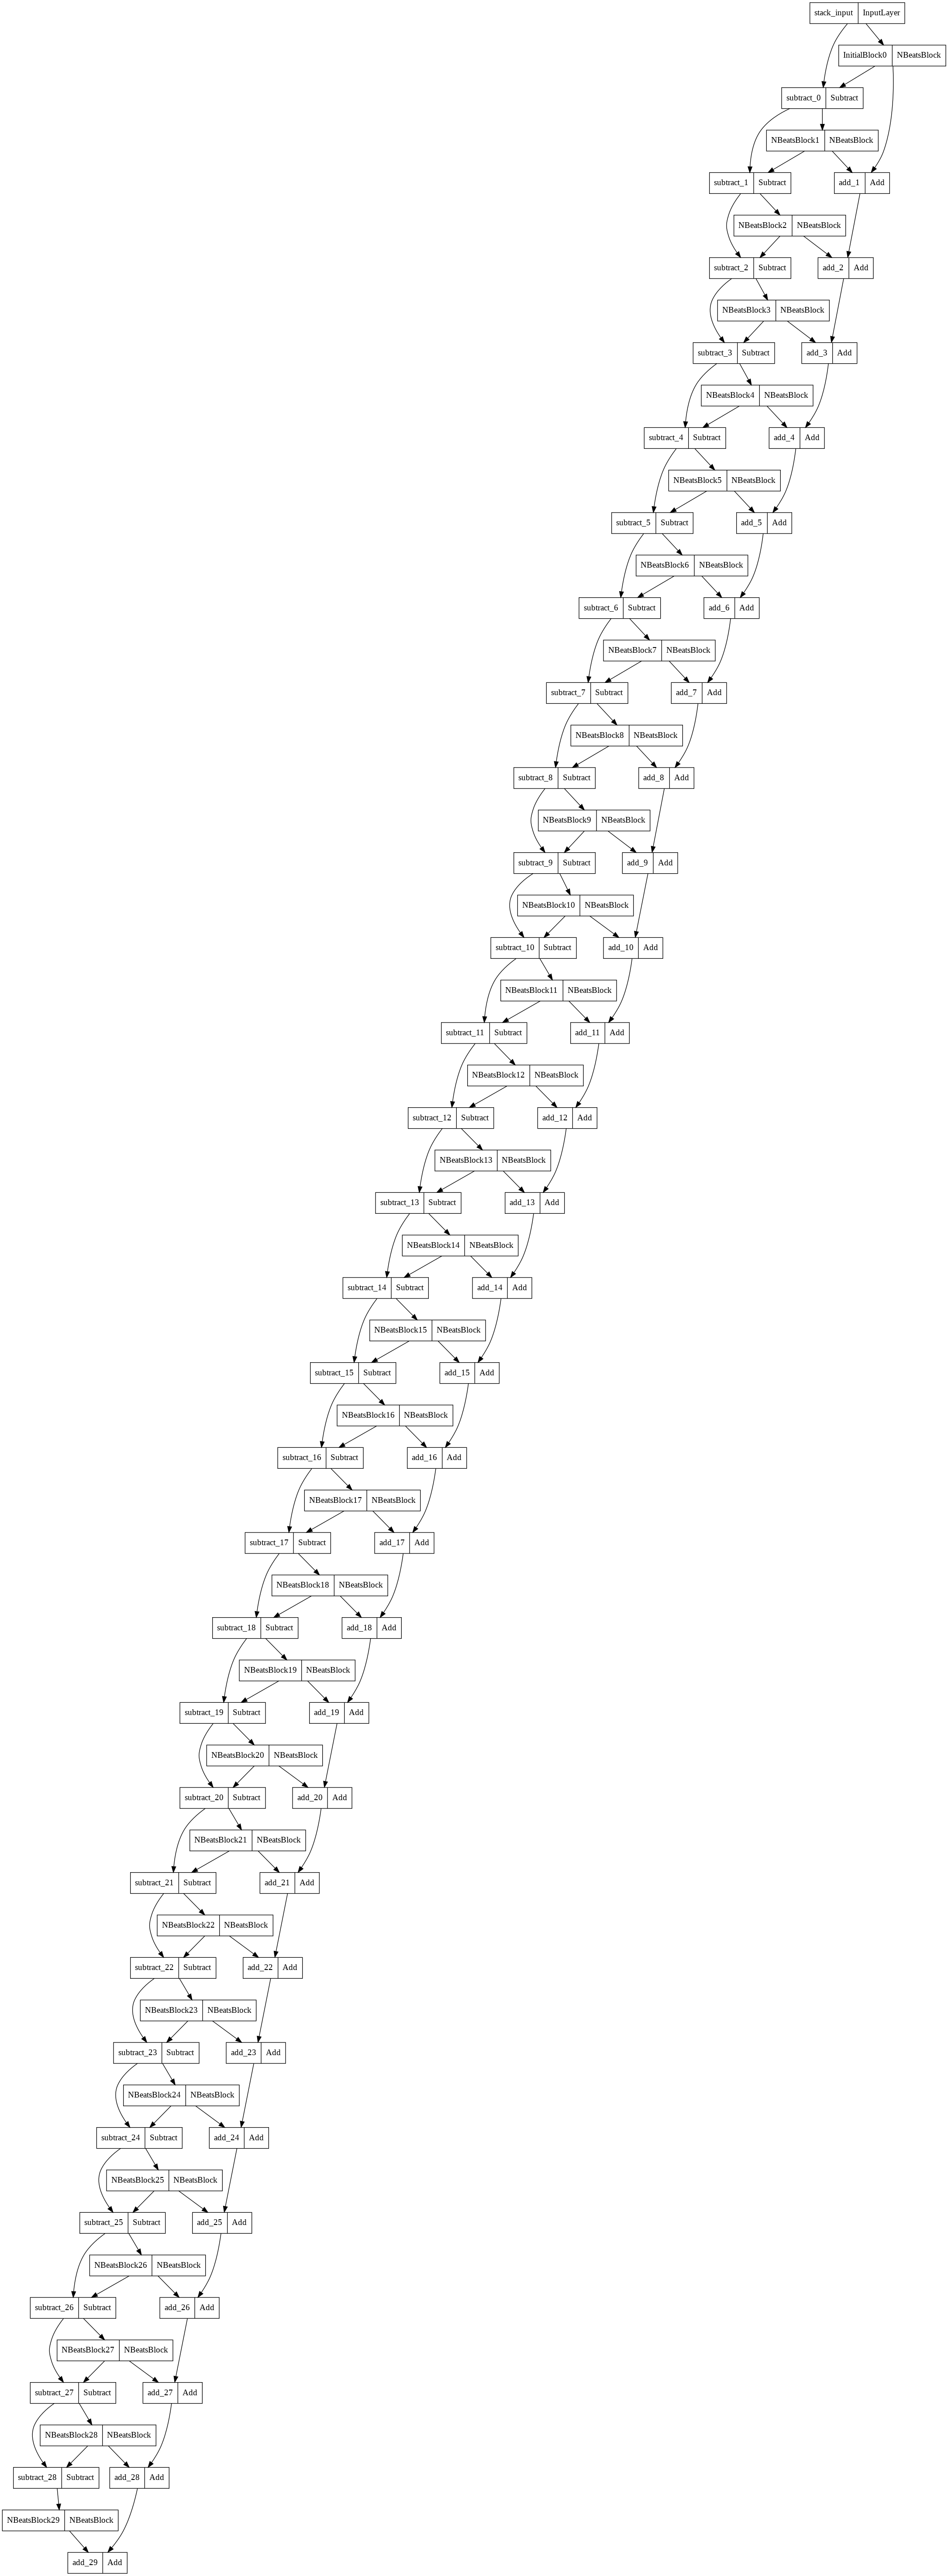

In [83]:
# Plot the model for a summary
plot_model(model_5)

In [84]:
# Save and load the model
model_5.save(model_5.name)

INFO:tensorflow:Assets written to: model_5_NBeats/assets


INFO:tensorflow:Assets written to: model_5_NBeats/assets


In [85]:
loaded_model_5 = tf.keras.models.load_model('/content/model_5_NBeats',
                                            custom_objects={'NBeatsBlock': NBeatsBlock})

In [86]:
# Evaluate the loaded the model to see if it's the same as the saved model
loaded_model_5.evaluate(test_dataset)

1/1 [==============================] - 1s 1s/step - loss: 585.1768 - mae: 585.1768 - mse: 1223961.1250


[585.1767578125, 585.1767578125, 1223961.125]

## Ensemble of models
A combination of the following models is used:
*  Models with different loss functions (MAE, MSE, MAPE)
*  Randomly initialized models

### Construct ensemble of trained models

In [87]:
# Create a function to produce a list of different models with different loss functions
def get_ensemble_models(horizon=HORIZON,
                        train_data=train_dataset,
                        test_data=test_dataset,
                        num_iter=10,
                        num_epochs=100,
                        loss_fns=['mae', 'mse', 'mape']):
  """
  Return a list of num_iter models each trained on mas, mse, mape loss.
  
  For example, if num_iter=10, a list of 30 trained models will be returned:
  10 * len(["mae", "mse", "mape"]).
  """
  # Make empty list for trained ensemble models
  ensemble_models = []

  # Create num_iter models per loss function
  for i in range(num_iter):
    for loss_function in loss_fns:
      print(f'Optimizing model by reducing {loss_function} for {num_epochs} epochs, model number: {i}')

      # Construct a single model
      model = tf.keras.Sequential([layers.Dense(128, kernel_initializer='he_normal', activation='relu'),
                                   layers.Dense(128, kernel_initializer='he_normal', activation='relu'),
                                   layers.Dense(HORIZON)])
      # Compile the single model with current loss function
      model.compile(loss=loss_function,
                    optimizer=tf.keras.optimizers.Adam(),
                    metrics=['mae', 'mse'])
      # Fit the model
      model.fit(train_data,
               epochs=num_epochs,
               verbose=0,
               validation_data=test_data,
               callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=200, restore_best_weights=True),
                          tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=100, verbose=1)])
      
      # Append fitted model to the list of ensemble models
      ensemble_models.append(model)
  
  return ensemble_models

In [88]:
%%time
# Get list of trained models
ensemble_models = get_ensemble_models(num_iter=5, num_epochs=1000)

Optimizing model by reducing mae for 1000 epochs, model number: 0

Epoch 973: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Optimizing model by reducing mse for 1000 epochs, model number: 0

Epoch 429: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 529: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing mape for 1000 epochs, model number: 0

Epoch 214: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 529: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 629: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Optimizing model by reducing mae for 1000 epochs, model number: 1

Epoch 578: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 788: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 888: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Optimizing mode

### Make predictions with the ensemble model

In [89]:
# Create a function to return a list of predictions of each trained model
def make_ensemble_preds(ensemble_model, data):
  ensemble_preds = []
  for model in ensemble_models:
    preds = model.predict(data)
    ensemble_preds.append(preds)
  return tf.constant(tf.squeeze(ensemble_preds))

In [90]:
# Get a list of predictions
ensemble_preds = make_ensemble_preds(ensemble_models, test_dataset)
ensemble_preds

<tf.Tensor: shape=(15, 556), dtype=float32, numpy=
array([[ 8713.674 ,  8736.761 ,  9091.626 , ..., 49593.367 , 49002.996 ,
        47599.89  ],
       [ 8804.622 ,  8725.384 ,  8993.1455, ..., 49696.5   , 48237.824 ,
        46180.11  ],
       [ 8797.546 ,  8807.256 ,  9071.199 , ..., 49981.723 , 47984.87  ,
        45738.98  ],
       ...,
       [ 8830.661 ,  8782.663 ,  9099.959 , ..., 50152.727 , 48907.887 ,
        46260.832 ],
       [ 8785.646 ,  8781.293 ,  9062.581 , ..., 50109.48  , 48588.824 ,
        45642.87  ],
       [ 8802.43  ,  8790.326 ,  9081.08  , ..., 48483.71  , 48102.55  ,
        45019.605 ]], dtype=float32)>

### Evaluate ensemble models predictions

In [91]:
ensemble_results = evaluate_preds(y_true=y_test, y_pred=np.median(ensemble_preds, axis=0))
ensemble_results

{'MAE': 570.9556,
 'MAPE': 2.5722249,
 'MASE': 1.0030109,
 'MSE': 1149010.5,
 'RMSE': 1071.9191}

### Plot prediction intervals
Adopt 95% confidence intervals to plot the uncertainty estimates.

In [92]:
def get_upper_lower(preds):
  # Measure the standard deviation of predictions
  std = tf.math.reduce_std(preds, axis=0)
  # Get interval
  interval = 1.96 * std
  # Get upper and lower bounds
  preds_mean = tf.math.reduce_mean(preds, axis=0)
  upper = preds_mean + interval
  lower = preds_mean - interval
  return lower, upper

In [93]:
lower, upper = get_upper_lower(ensemble_preds)
lower, upper

(<tf.Tensor: shape=(556,), dtype=float32, numpy=
 array([ 8734.048 ,  8716.484 ,  8981.4375,  8665.823 ,  8673.735 ,
         8662.362 ,  8607.345 ,  8406.201 ,  8413.643 ,  8474.231 ,
         8144.0645,  8054.471 ,  7999.5845,  7561.4927,  7197.3213,
         7187.325 ,  7003.6953,  7120.497 ,  7041.666 ,  7436.8867,
         7324.914 ,  7676.7856,  7489.327 ,  7341.5503,  7264.2314,
         7257.421 ,  7145.673 ,  7340.6943,  7458.3022,  7495.1753,
         7520.4126,  7288.679 ,  7186.5596,  7136.4272,  7142.787 ,
         7192.132 ,  7035.597 ,  7072.435 ,  6832.207 ,  6533.1855,
         7291.2915,  7074.8135,  7046.9316,  7175.8896,  7174.712 ,
         7122.0664,  7183.704 ,  7168.66  ,  7143.383 ,  7185.217 ,
         7270.658 ,  7350.698 ,  7204.541 ,  7136.484 ,  7126.965 ,
         6909.3203,  7227.9053,  7275.2505,  7305.5005,  7682.3755,
         7988.325 ,  8066.1465,  7774.2676,  8024.532 ,  8035.9946,
         8123.4688,  8054.5757,  8658.062 ,  8824.138 ,  8697.083 ,

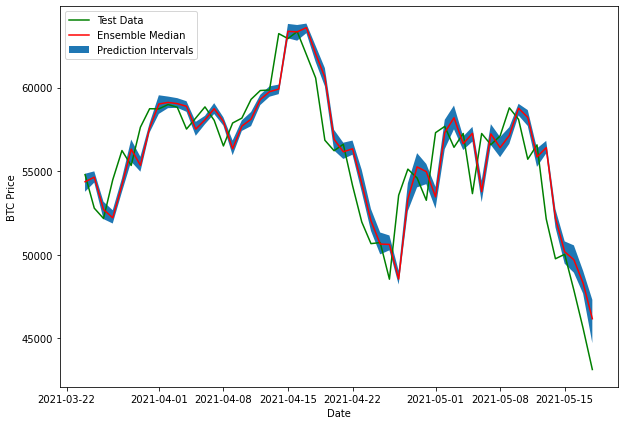

In [94]:
# Get the median values ensemble predictions
ensemble_median = np.median(ensemble_preds, axis=0)

# Plot the median of ensemble predictions along with the prediction intervals (where the predictions fall between)
offset=500
plt.figure(figsize=(10, 7))
plt.plot(X_test.index[offset:], y_test[offset:], 'g', label='Test Data')
plt.plot(X_test.index[offset:], ensemble_median[offset:], 'r', label='Ensemble Median')
plt.xlabel('Date')
plt.ylabel('BTC Price')
plt.fill_between(X_test.index[offset:], (lower)[offset:],
                                      (upper)[offset:], label='Prediction Intervals')
plt.legend(loc='upper left', fontsize=10)

## Model predicting into actual-future
This is a model that trained on the full historical data, and is re-trained everytime a forecast is made.

In [95]:
bitcoin_prices_windowed.head(10)

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2013-10-01,123.65499,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,25,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,25,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,25,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,25,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN
2013-10-06,120.65533,25,121.33866,118.67466,108.58483,125.45500,123.65499,NaN,NaN
2013-10-07,121.79500,25,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499,NaN
2013-10-08,123.03300,25,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499
2013-10-09,124.04900,25,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500


In [96]:
# Prepare the entire datasets
X_all = bitcoin_prices_windowed.dropna().drop(['Price', 'block_reward'], axis=1).to_numpy()
y_all = bitcoin_prices_windowed.dropna()['Price'].to_numpy()

In [97]:
np.shape(y_all)

(2780,)

In [98]:
# Create a function to make into future
def make_future_forecast(features, labels, model, epochs, into_future, window_size=7, horizon=1):
  """
  Makes forecast into into_future steps and update dataset and retrain the model
  on the updated dataset every time when a forecast is made.

  Args:
    features: Windowed data of the Bitcoin prices.
    labels: True values of Bitcoin prices.
    epochs: Number of epochs the model will be trained.
    model: The model used to train on the full dataset.
    into_future(int): Number of steps into the future the model predicts in an actual_prediction experiment.
    window_size (int): Length of each windowed features, default to 7.
    horizon: Number of steps to predict into the future based on windowed data.

  Returns a list of future predictions into into_future steps.
  """
  future_predictions = []
  
  for i in range(into_future):
    last_window = labels[-window_size:]
    model.fit(features, 
             labels,
             epochs=epochs,
             verbose=0)
    future_pred = model.predict(tf.expand_dims(last_window, axis=0))
    print(f'Predicting on {last_window} --> Prediction: {tf.squeeze(future_pred).numpy()}\n')
    future_predictions.append(tf.squeeze(future_pred).numpy())

    # Update dataset
    features = np.append(features[1:], last_window[np.newaxis,:], axis=0)
    labels = np.append(labels[1:], tf.squeeze(future_pred).numpy())
  return future_predictions

In [99]:
# Make into futures for 14 steps
future_predictions = make_future_forecast(X_all, y_all, model_5, epochs=10, into_future=14)

Predicting on [56573.5554719  52147.82118698 49764.1320816  50032.69313676
 47885.62525472 45604.61575361 43144.47129086] --> Prediction: 55962.07421875

Predicting on [52147.82118698 49764.1320816  50032.69313676 47885.62525472
 45604.61575361 43144.47129086 55962.07421875] --> Prediction: 51780.05078125

Predicting on [49764.1320816  50032.69313676 47885.62525472 45604.61575361
 43144.47129086 55962.07421875 51780.05078125] --> Prediction: 46989.10546875

Predicting on [50032.69313676 47885.62525472 45604.61575361 43144.47129086
 55962.07421875 51780.05078125 46989.10546875] --> Prediction: 52374.63671875

Predicting on [47885.62525472 45604.61575361 43144.47129086 55962.07421875
 51780.05078125 46989.10546875 52374.63671875] --> Prediction: 54405.28125

Predicting on [45604.61575361 43144.47129086 55962.07421875 51780.05078125
 46989.10546875 52374.63671875 54405.28125   ] --> Prediction: 44606.28125

Predicting on [43144.47129086 55962.07421875 51780.05078125 46989.10546875
 52374.

In [100]:
future_predictions

[55962.074,
 51780.05,
 46989.105,
 52374.637,
 54405.28,
 44606.28,
 39316.273,
 57632.75,
 57660.367,
 43244.758,
 51185.457,
 57061.793,
 52617.84,
 40498.91]

In [101]:
# Plot the future predictions
def get_future_dates(start_date, into_future, offset=1):
  """
  Return a range of datetime values from start_date to start_date+into_future steps.

  Args:
    start_date: date to start range (np.datetime64)
    into_future: number of days to add onto start date for range (int)
    offset: number of days to offset start_date by (default 1)
  """
  start_date = start_date + np.timedelta64(offset, 'D')
  end_date = start_date + np.timedelta64(into_future, 'D')
  return np.arange(start_date, end_date, dtype='datetime64[D]')

In [102]:
# Get the last timestep of the data
last_timestep = bitcoin_prices_windowed.index[-1]
last_timestep

Timestamp('2021-05-18 00:00:00')

In [103]:
# Get target timesteps
next_time_steps = get_future_dates(last_timestep, 14)
next_time_steps

array(['2021-05-19', '2021-05-20', '2021-05-21', '2021-05-22',
       '2021-05-23', '2021-05-24', '2021-05-25', '2021-05-26',
       '2021-05-27', '2021-05-28', '2021-05-29', '2021-05-30',
       '2021-05-31', '2021-06-01'], dtype='datetime64[D]')

In [104]:
# Insert last timestep/final price so the graph dosen's have a gap
next_time_steps = np.insert(next_time_steps, 0, last_timestep)
future_predictions = np.insert(future_predictions, 0, bitcoin_prices_windowed.dropna()['Price'][-1])
next_time_steps, future_predictions

(array(['2021-05-18', '2021-05-19', '2021-05-20', '2021-05-21',
        '2021-05-22', '2021-05-23', '2021-05-24', '2021-05-25',
        '2021-05-26', '2021-05-27', '2021-05-28', '2021-05-29',
        '2021-05-30', '2021-05-31', '2021-06-01'], dtype='datetime64[D]'),
 array([43144.473, 55962.074, 51780.05 , 46989.105, 52374.637, 54405.28 ,
        44606.28 , 39316.273, 57632.75 , 57660.367, 43244.758, 51185.457,
        57061.793, 52617.84 , 40498.91 ], dtype=float32))

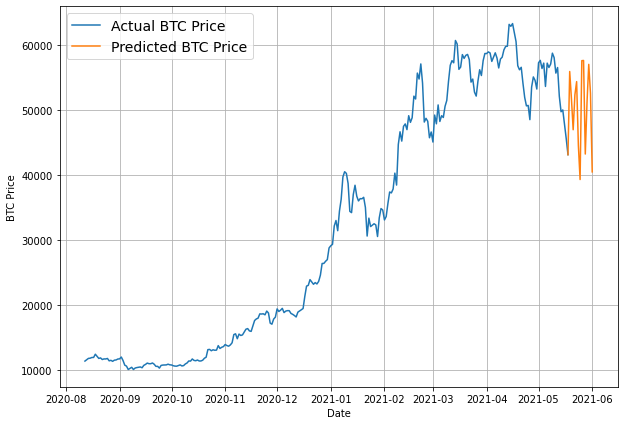

In [105]:
# Plot future price predictions of Bitcoin
plt.figure(figsize=(10, 7))
plot_time_series(bitcoin_prices_windowed.dropna().index, bitcoin_prices_windowed.dropna()['Price'], start=2500, format="-", label="Actual BTC Price")
plot_time_series(next_time_steps, future_predictions, format="-", label="Predicted BTC Price")

# Compare models

In [108]:
# compare results of different models
model_results = pd.DataFrame({'Naive_model': naive_results,
                              'model_1_Dense_univariate': model_1_results,
                              'model_2_Conv1D': model_2_results,
                              'model_3_LSTM': model_3_results,
                              'model_4_Dense_multivariate': model_4_results,
                              'model_5_NBeats': model_5_results,
                              'model_6_Ensemble': ensemble_results}).T
model_results

,MAE,MSE,RMSE,MAPE,MASE
Naive_model,567.980225,1147547.000,1071.236206,2.516525,0.999570
model_1_Dense_univariate,1237.506470,5405198.500,1425.747803,5.558879,2.202073
model_2_Conv1D,570.828369,1176671.250,1084.744751,2.559336,1.002787
model_3_LSTM,594.602966,1267231.875,1125.713867,2.671757,1.044553
model_4_Dense_multivariate,567.889893,1164816.375,1079.266602,2.546076,0.997625
model_5_NBeats,585.176636,1223960.875,1106.327637,2.656963,1.027993
model_6_Ensemble,570.955627,1149010.500,1071.919067,2.572225,1.003011


In [117]:
# Get the performance the naive_model for reference
reference = model_results.loc['Naive_model']['MAE']
reference

567.9802

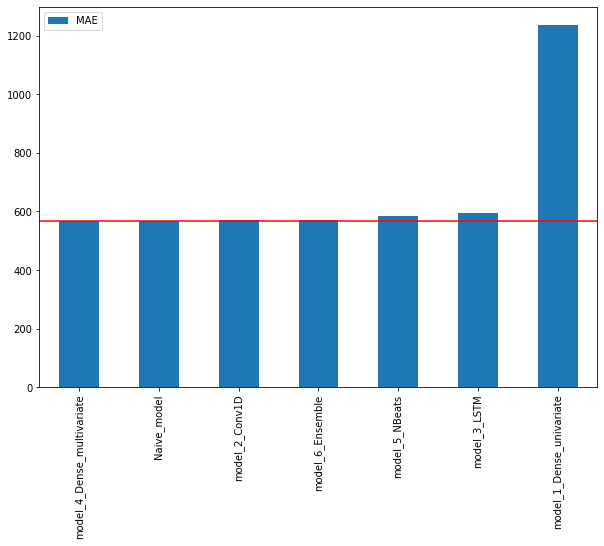

In [118]:
# Sort model results by MAE and plot
model_results[['MAE']].sort_values(by='MAE').plot(figsize=(10, 7), kind='bar')
plt.axhline(y = reference, color = 'r', linestyle = '-')